In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nfl_data_py as nfl

# Define the years to import
yrs = range(2019, 2020)
#yrs = 2022

# Play-by-Play Data
pbp_data = nfl.import_pbp_data(years=yrs)

# Player Stats
#player_stats = nfl.import_seasonal_data(years=yrs, s_type='ALL')

# Weekly Rosters
#weekly_rosters = nfl.import_weekly_rosters(years=yrs)

# Schedules
#schedules = nfl.import_schedules(years=yrs)

# Injuries
#injuries = nfl.import_injuries(years=yrs)

# Draft Data
#draft_data = nfl.import_draft_picks(years=yrs)

# Combine Data
#combine_data = nfl.import_combine_data(years=yrs)

# Weekly Fantasy Data
weekly_fantasy_data = nfl.import_weekly_data(years=yrs)

# Officiating Data
#officiating_data = nfl.import_officials(years=yrs)

# Betting Lines
#betting_lines = nfl.import_sc_lines(yrs)

# Depth Charts
depth_charts = nfl.import_depth_charts(years=yrs)

# Next Gen Stats
#next_gen_stats = nfl.import_ngs_data(years=yrs, stat_type='passing')

2019 done.
Downcasting floats.
Downcasting floats.


In [2]:
#nfl.import_contracts()

In [3]:
#nfl.import_ngs_data(years=yrs, stat_type='receiving').columns

Attempt to make a dvoa-type metric. Explore how downs impact expected points to make a better epa. 
- Points Above Replacement [PAR]
- First Down Above Replacement [FDAR] how likely are you to obtain another first down on this drive?

Use strength of schedule and matchups to weight player performance. Include situations like 4th quarter.

Can I predict snap count of players? If so, does that help predict points or yards?

Make multiple functions that take in past data (play-by-play) 
- summarize the data by predicting the play outcome (yardage gained, score, 1st down)

Make a function that is able to summarize the effect of each variable on the outcome of the play

So, if each play occurs after the prior; I can make a cumulative sum that tracks the performance of teams
- New features like: Of last 100 plays how many have been touchdowns? How many have been sacks?
- total plays played

Can I feed all columns into a model to predict the future?
- Should I predict the next play? The game result? The next game result? Season win total?
- Can I find the most important features to then summarize for other problems? Can I then reduce the dimensions?
- Or should I just use averages and tendencies to summarize the current data in relation to future data?

Right now there is too much data for each player to put into one dataset to predict the next play. Goal: features for each player on the field (past yards, height, age...), but that would amount to about 200 columns and millions of rows. So, there must be feature reduction so that each player only has three or four columns to their name resulting in about 80 columns and millions of rows.
- Feature engineering to organize players based on three or four categories (athletisism, schemes, accolades...)
    - Production (reference for a category to qualify as being good)
        - explosive play rate
        - clutch rating
        - performance after explosive plays
        - consistency rating
        - teammate assistance
        - luck rating (drops, fumble recovery, missed field goals)
    - Tangibles (Athleticism)
        - age, age trends for position
        - height
        - weight
        - speed
        - strength
        - change in weight
        - injuries, return to injury effectiveness
        - total tackles endured
        - performance drop off on short rest times (thursday night games)
    - Schemes (Usage)
        - percent of snaps throwing, catching, running the ball (of specific player and of team)
        - 2-minute drill snap percentage
        - percent of snaps at each position
        - personnel frequencies
        - down/redzone usage
        - aggressiveness rating
        - contact rate (tackle rate)
    - Accolades (Intangibles)
        - salary
        - awards
        - draft stock
        - playoff wins
        - betting lines
        - how many teams have they been on?
- Reduce dimension through cluster analysis (referencing production differences)
- Combine all categories for each player on each play to predict the future

Similar approach could be to pivot the teammate/matchup/situation stats into long format for each player. The columns would be personal to each player, and the rows would have duplicated on the play dimension, meaning that each play would have 22 rows instead of one row for each play.

Develop Value Over Environment (VOE). Incorporate all situational stats (game time, personnel, home/away, teammate performance, teammate situational performance) to predict the outcome of the play. The difference between cumulative expectation and cumulative outcome for each individual player is assumed to be the fault of the individual player.

In [4]:
game_info = [
    'play_id', 'game_id', 'old_game_id_x', 'home_team', 'away_team', 'season_type', 'week', 
    'game_date', 'total_home_score', 'total_away_score', 'posteam', 'posteam_type', 'defteam', 
    'location', 'stadium', 'weather', 'temp', 'wind', 'roof', 'surface', 'home_coach', 'away_coach', 
    'stadium_id', 'game_stadium', 'away_score', 'home_score', 'result', 'total', 'spread_line', 
    'total_line', 'div_game', 'home_opening_kickoff', 'nflverse_game_id', 'old_game_id_y'
]

drive_info = [
    'drive', 'drive_real_start_time', 'drive_play_count', 'drive_time_of_possession', 
    'drive_first_downs', 'drive_inside20', 'drive_ended_with_score', 'drive_quarter_start', 
    'drive_quarter_end', 'drive_yards_penalized', 'drive_start_transition', 'drive_end_transition', 
    'drive_game_clock_start', 'drive_game_clock_end', 'drive_start_yard_line', 'drive_end_yard_line', 
    'drive_play_id_started', 'drive_play_id_ended', 'fixed_drive', 'fixed_drive_result'
]

play_info = [
    'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 
    'quarter_end', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 
    'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 
    'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 
    'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 
    'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 
    'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
    'score_differential', 'posteam_score', 'defteam_score', 'posteam_score_post', 'defteam_score_post', 
    'score_differential_post', 'no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 
    'fg_prob', 'safety_prob', 'td_prob', 'extra_point_prob', 'two_point_conversion_prob', 'ep', 'epa', 
    'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 'total_away_rush_epa', 
    'total_home_pass_epa', 'total_away_pass_epa', 'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa', 
    'total_home_comp_air_epa', 'total_away_comp_air_epa', 'total_home_comp_yac_epa', 
    'total_away_comp_yac_epa', 'total_home_raw_air_epa', 'total_away_raw_air_epa', 
    'total_home_raw_yac_epa', 'total_away_raw_yac_epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 
    'vegas_wpa', 'vegas_home_wpa', 'home_wp_post', 'away_wp_post', 'vegas_wp', 'vegas_home_wp', 
    'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 'total_away_pass_wpa', 
    'air_wpa', 'yac_wpa', 'comp_air_wpa', 'comp_yac_wpa', 'total_home_comp_air_wpa', 
    'total_away_comp_air_wpa', 'total_home_comp_yac_wpa', 'total_away_comp_yac_wpa', 
    'total_home_raw_air_wpa', 'total_away_raw_air_wpa', 'total_home_raw_yac_wpa', 'total_away_raw_yac_wpa'
]

player_actions = [
    'rush_attempt', 'pass_attempt', 'sack', 'qb_hit', 'qb_hit_1_player_id', 'qb_hit_1_player_name', 
    'qb_hit_2_player_id', 'qb_hit_2_player_name', 'solo_tackle', 'assist_tackle', 'tackled_for_loss', 
    'tackle_for_loss_1_player_id', 'tackle_for_loss_1_player_name', 'tackle_for_loss_2_player_id', 
    'tackle_for_loss_2_player_name', 'forced_fumble_player_1_team', 'forced_fumble_player_1_player_id', 
    'forced_fumble_player_1_player_name', 'forced_fumble_player_2_team', 'forced_fumble_player_2_player_id', 
    'forced_fumble_player_2_player_name', 'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 
    'fumble_lost', 'fumble_recovery_1_team', 'fumble_recovery_1_yards', 'fumble_recovery_1_player_id', 
    'fumble_recovery_1_player_name', 'fumble_recovery_2_team', 'fumble_recovery_2_yards', 
    'fumble_recovery_2_player_id', 'fumble_recovery_2_player_name', 'interception', 'interception_player_id', 
    'interception_player_name', 'lateral_interception_player_id', 'lateral_interception_player_name', 
    'pass_defense_1_player_id', 'pass_defense_1_player_name', 'pass_defense_2_player_id', 
    'pass_defense_2_player_name', 'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 
    'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch', 'own_kickoff_recovery', 
    'own_kickoff_recovery_td', 'own_kickoff_recovery_player_id', 'own_kickoff_recovery_player_name', 
    'blocked_player_id', 'blocked_player_name', 'punt_returner_player_id', 'punt_returner_player_name', 
    'kickoff_returner_player_id', 'kickoff_returner_player_name', 'punter_player_id', 'punter_player_name', 
    'kicker_player_id', 'kicker_player_name', 'passer_player_id', 'passer_player_name', 'passing_yards', 
    'receiver_player_id', 'receiver_player_name', 'receiving_yards', 'rusher_player_id', 'rusher_player_name', 
    'rushing_yards', 'lateral_receiver_player_id', 'lateral_receiver_player_name', 'lateral_receiving_yards', 
    'lateral_rusher_player_id', 'lateral_rusher_player_name', 'lateral_rushing_yards', 'lateral_sack_player_id', 
    'lateral_sack_player_name', 'assist_tackle_1_player_id', 'assist_tackle_1_player_name', 
    'assist_tackle_1_team', 'assist_tackle_2_player_id', 'assist_tackle_2_player_name', 
    'assist_tackle_2_team', 'assist_tackle_3_player_id', 'assist_tackle_3_player_name', 
    'assist_tackle_3_team', 'assist_tackle_4_player_id', 'assist_tackle_4_player_name', 
    'assist_tackle_4_team', 'solo_tackle_1_team', 'solo_tackle_2_team', 'solo_tackle_1_player_id', 
    'solo_tackle_2_player_id', 'solo_tackle_1_player_name', 'solo_tackle_2_player_name', 'fumbled_1_team', 
    'fumbled_1_player_id', 'fumbled_1_player_name', 'fumbled_2_player_id', 'fumbled_2_player_name', 
    'fumbled_2_team', 'return_team', 'return_yards', 'penalty_team', 'penalty_player_id', 
    'penalty_player_name', 'penalty_yards', 'penalty', 'penalty_type', 'replay_or_challenge', 
    'replay_or_challenge_result', 'defensive_two_point_attempt', 'defensive_two_point_conv', 
    'defensive_extra_point_attempt', 'defensive_extra_point_conv', 'first_down_rush', 'first_down_pass', 
    'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'touchback', 'safety', 'tackled_for_loss', 'fumble', 
    'complete_pass', 'lateral_reception', 'lateral_rush', 'lateral_return', 'lateral_recovery', 
    'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown', 'extra_point_attempt', 
    'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 'punt_attempt'
]

special_teams = [
    'special_teams_play', 'st_play_type', 'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 
    'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch', 'own_kickoff_recovery', 
    'own_kickoff_recovery_td', 'punt_returner_player_id', 'punt_returner_player_name', 
    'kickoff_returner_player_id', 'kickoff_returner_player_name', 'punter_player_id', 'punter_player_name', 
    'kicker_player_id', 'kicker_player_name', 'blocked_player_id', 'blocked_player_name'
]

clock_and_time = [
    'start_time', 'time_of_day', 'play_clock', 'end_clock_time', 'drive_game_clock_start', 
    'drive_game_clock_end'
]

advanced_metrics = [
    'cp', 'cpoe', 'series', 'series_success', 'series_result', 'order_sequence', 'nfl_api_id', 
    'play_deleted', 'play_type_nfl', 'aborted_play', 'success', 'passer', 'passer_jersey_number', 
    'rusher', 'rusher_jersey_number', 'receiver', 'receiver_jersey_number', 'pass', 'rush', 'first_down', 
    'special', 'play', 'passer_id', 'rusher_id', 'receiver_id', 'name', 'jersey_number', 'id', 
    'fantasy_player_name', 'fantasy_player_id', 'fantasy', 'fantasy_id', 'out_of_bounds', 'qb_epa', 
    'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd', 'xpass', 
    'pass_oe', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 
    'defense_personnel', 'number_of_pass_rushers', 'players_on_play', 'offense_players', 'defense_players', 
    'n_offense', 'n_defense', 'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route', 
    'defense_man_zone_type', 'defense_coverage_type'
]

## Import context analysis

In [5]:
# 'C:\Users\Jack\Documents\GitHub\FFInsights\context_preds.csv'
context_forecast_df = pd.read_csv(r'C:\Users\Jack\Documents\GitHub\FFInsights\context_preds.csv')
context_forecast_df.head()

,game_id,play_id,epa,o_formation_reuse,variance_encoder,ep,dist_down,d_coverage_reuse,play_type_run,log_yardline,...,qtr,yardline_wp,xpass_receivers,prev_yards_gain,temp,xpass,yardline_per_sec,Base_predictions,shrinked_preds,residual_epa
0,2015_01_BAL_DEN,51.0,-0.337139,NaN,0.0,0.239785,10.0,NaN,0,4.394449,...,1.0,33.761932,NaN,NaN,88.0,0.456481,0.044444,-0.147256,-0.008773,-0.328366
1,2015_01_BAL_DEN,75.0,-0.262481,NaN,0.0,-0.097354,14.0,NaN,1,4.356709,...,1.0,32.386150,NaN,3.0,88.0,0.545905,0.043429,-0.017706,-0.001055,-0.261426
2,2015_01_BAL_DEN,96.0,1.661242,NaN,0.0,-0.359835,15.0,NaN,0,4.330733,...,1.0,30.247120,NaN,2.0,88.0,0.968533,0.043303,-0.168260,-0.010024,1.671266
3,2015_01_BAL_DEN,120.0,-0.518931,NaN,0.0,1.301407,10.0,NaN,1,4.189655,...,1.0,29.162455,NaN,10.0,88.0,0.448571,0.038371,-0.267497,-0.015937,-0.502994
4,2015_01_BAL_DEN,141.0,-0.449598,NaN,0.0,0.782476,20.0,NaN,0,4.189655,...,1.0,27.988186,NaN,0.0,88.0,0.489852,0.039394,-0.162966,-0.009709,-0.439889


## Transform to Wide Format

In [6]:
def pivot_wide_both_sides(data):
    import warnings
    warnings.filterwarnings('ignore')

    # Filter for valid play types
    data = data[data['play_type'].isin(['run', 'pass'])].copy()

    # Sort for consistency
    data = data.sort_values(['game_id', 'play_id'])

    # Helper function to expand player columns
    def expand_player_col(df, col_name):
        side = col_name.split('_')[0]  # offense or defense

        # Fill missing with empty string to allow split
        players_split = df[col_name].fillna('').str.split(';')

        # Pad each list to exactly 11 players (or truncate)
        players_list = players_split.apply(lambda lst: (lst + [None]*11)[:11])

        # Convert to DataFrame
        players_df = pd.DataFrame(players_list.tolist(), columns=[f'{side}_player_{i+1}' for i in range(11)])

        return players_df

    # Expand offense and defense player columns
    offense_wide = expand_player_col(data, 'offense_players')
    defense_wide = expand_player_col(data, 'defense_players')

    # Concatenate expanded columns with the original DataFrame
    pbp_wide = pd.concat([data.reset_index(drop=True), offense_wide, defense_wide], axis=1)

    # Drop potential duplicates
    pbp_wide = pbp_wide.drop_duplicates(subset=['game_id', 'play_id'])

    # Drop rows with NaN in offense_players or defense_players
    pbp_wide = pbp_wide.dropna(subset=['offense_players', 'defense_players'])

    return pbp_wide

## Clean depth_charts

In [7]:
def clean_depth_charts(depth_charts):
    # Remove duplicates on season, club_code, week, gsis_id
    depth_charts_copy = depth_charts.drop_duplicates(subset=['season', 'club_code', 'week', 'gsis_id'])
    depth_charts_copy = depth_charts_copy[depth_charts_copy['formation'].str.contains('Offense|Defense', regex=True)].copy()

    # Replace 'T' and 'G' in 'position' with the value from 'depth_position'
    depth_charts_copy['position'] = np.where(
        depth_charts_copy['position'].isin(['T', 'G']),
        depth_charts_copy['depth_position'],
        depth_charts_copy['position']
    )

    # Replace 'LOT' in 'position'
    depth_charts_copy['position'] = np.where(
        depth_charts_copy['position'].isin(['LOT']),
        'LT',
        depth_charts_copy['position']
    )

    # Replace 'ROT' in 'position'
    depth_charts_copy['position'] = np.where(
        depth_charts_copy['position'].isin(['ROT']),
        'RT',
        depth_charts_copy['position']
    )

    # Replace 'RDE' and 'LDE'
    depth_charts_copy['position'] = np.where(
        depth_charts_copy['position'].isin(['RDE', 'LDE']),
        'DE',
        depth_charts_copy['position']
    )    
    
    # Replace 'DB' with 'CB'
    depth_charts_copy['position'] = np.where(
        depth_charts_copy['position'].isin(['LB']),
        'MLB',
        depth_charts_copy['position']
    )

    # Replace 'K', 'P', 'LS'
    depth_charts_copy['position'] = np.where(
        depth_charts_copy['position'].isin(["\n ", 'K', 'P', 'LS']),
        'special',
        depth_charts_copy['position']
    )

    # Replace 'DB' with 'CB'
    depth_charts_copy['position'] = np.where(
        depth_charts_copy['position'].isin(['DB']),
        'CB',
        depth_charts_copy['position']
    )

    # Replace '\n'
    depth_charts_copy['position'] = np.where(
        depth_charts_copy['position'].str.contains(' '),
        'special',
        depth_charts_copy['position']
    )

    # Replace 'SBBYE'
    depth_charts_copy['week'] = np.where(
        depth_charts_copy['week'].isna(),
        '23',
        depth_charts_copy['week']
    )

    # Seniority counter
    depth_charts_copy['seniority'] = depth_charts_copy.groupby(['gsis_id']).cumcount() + 1

    # Cumulative sum of depth_team per gsis_team
    depth_charts_copy['depth_team'] = depth_charts_copy['depth_team'].astype(int)
    depth_charts_copy['depth_team_sum'] = depth_charts_copy.groupby(['gsis_id'])['depth_team'].cumsum()

    # Cumulative mean of depth_team per gsis_team
    depth_charts_copy['depth_team_mean'] = depth_charts_copy['depth_team_sum'] / depth_charts_copy['seniority']

    # Sort by season, club_code, week, position, depth_team_mean
    depth_charts_copy = depth_charts_copy.sort_values(['depth_team_mean'], ascending=True)

    # Cumulative count of season, week, club_team, position
    depth_charts_copy['depth_team_estimator'] = depth_charts_copy.groupby(['season', 'week', 'club_code', 'position']).cumcount() + 1
    
    #depth_charts_copy['depth_team_estimator'] = depth_charts_copy['depth_team_estimator'].astype(int)
    depth_charts_copy['depth_team_estimator'] = depth_charts_copy['depth_team_estimator'].astype(str)

    # Define position_label
    depth_charts_copy['position_label'] = depth_charts_copy['position'] + depth_charts_copy['depth_team_estimator'].astype(str)
    depth_charts_copy['season'] = depth_charts_copy['season'].astype(int)
    depth_charts_copy['gsis_id'] = depth_charts_copy['gsis_id'].astype(str)
    depth_charts_copy['week'] = depth_charts_copy['week'].astype(str).str.replace('.0', '', regex=False).astype(int)

    return depth_charts_copy

## Transform to Long Format

In [8]:
def pivot_long_both_sides(pbp_wide, depth_charts):
    import warnings
    warnings.filterwarnings('ignore')
    
    # Clean depth charts
    depth_charts_clean = clean_depth_charts(depth_charts)
    
    # Combine offense and defense player columns into long format
    long_df = pd.wide_to_long(
        pbp_wide.reset_index(),
        stubnames=['offense_player', 'defense_player'],
        i=['index'],  # preserves play-wise indexing
        j='player_number',
        sep='_',
        suffix='\\d+'
    ).reset_index()
    
    # Stack both sides
    offense_df = long_df[['game_id', 'play_id', 'offense_player', 'player_number', 'season', 'week']].copy()
    offense_df.rename(columns={'offense_player': 'player_id'}, inplace=True)

    defense_df = long_df[['game_id', 'play_id', 'defense_player', 'player_number', 'season', 'week']].copy()
    defense_df.rename(columns={'defense_player': 'player_id'}, inplace=True)
    
    all_long = pd.concat([offense_df, defense_df], ignore_index=True)

    # Merge with depth charts
    merged = all_long.merge(
        depth_charts_clean[['season', 'club_code', 'week', 'gsis_id', 'position_label', 'full_name']],
        left_on=['season', 'week', 'player_id'],
        right_on=['season', 'week', 'gsis_id'],
        how='left'
    )

    # Drop unnecessary
    merged = merged.drop(columns=['club_code', 'gsis_id'])

    # Filter nulls
    merged = merged.dropna(subset=['player_id', 'position_label'])

    # Deduplicate
    merged = merged.drop_duplicates(subset=['game_id', 'play_id', 'player_id'])

    return merged.sort_values(['game_id', 'play_id'])

# Feature Engineering

instead of looking at all the data at the same time, make multiple models for the most important aspects of each play (coverage type, offensive personnel, seconds remaining in half...) this way the models will automatically account for the different situations. the alternative is simple but risks losing info in the melting pot of combining all situational data into one signle model at the same time (deep learning might be able to account of the complexity).

is there data available to assign roles to players (left tackle, X reciever, blocking TE, zone CB, run stuffer DT...)?

create simple model for each position group that is dependent upon the unique metrics/stats that reflect the performance of the group (OL: time to throw, yards before contact...).

In [9]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca(df, feature_cols, n_components=3, prefix='pca'):
    """Standardize and reduce features using PCA, return new df with PC columns."""
    df_clean = df[feature_cols].dropna()
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(df_clean)
    pca_cols = [f'{prefix}_pc{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(components, columns=pca_cols, index=df_clean.index)
    return df.join(pca_df)

def epa_feature_engineering(pbp_long, context_forecast_df, diagnostics=False):
    if diagnostics:
        print(f'Initial size (GB): {pbp_long.memory_usage(deep=True).sum() / 1e9:.3f}')

    # Add residual epa to pbp_long
    pbp_long = pbp_long.merge(
        context_forecast_df, on=['game_id', 'play_id'], how='left'
    )

    # Contextual indicators
    pbp_long['is_pass'] = np.where(pbp_long['play_type'] == 'pass', 1, 0)
    pbp_long['is_run'] = np.where(pbp_long['play_type'] == 'run', 1, 0)
    pbp_long['outside_run'] = np.where(pbp_long['run_location'].isin(['left', 'right']), 1, 0)
    pbp_long['inside_run'] = np.where(pbp_long['run_location'].isin(['middle', 'up_middle']), 1, 0)
    pbp_long['wr_count'] = pbp_long['offense_personnel'].str.extract(r'(\d+)\s*WR').astype(float)
    pbp_long['redzone'] = np.where(pbp_long['yardline_100'] <= 20, 1, 0)
    pbp_long['backed_up'] = np.where(pbp_long['yardline_100'] >= 80, 1, 0)
    pbp_long['ones'] = 1

    pbp_long['yards_gained'] = pd.to_numeric(pbp_long['yards_gained'], errors='coerce')
    pbp_long['ydstogo'] = pd.to_numeric(pbp_long['ydstogo'], errors='coerce')
    pbp_long['was_pressure'] = pd.to_numeric(pbp_long['was_pressure'], errors='coerce')
    pbp_long['time_to_throw'] = pd.to_numeric(pbp_long['time_to_throw'], errors='coerce')
    pbp_long['wpa'] = pd.to_numeric(pbp_long['wpa'], errors='coerce')
    pbp_long['residual_epa'] = pd.to_numeric(pbp_long['residual_epa'], errors='coerce')

    # Now groupby after all columns are created
    grouped = pbp_long.groupby('player_id')
    decimal_places = 1

    # Cumulative stats
    pbp_long['cmltv_plyr_snaps'] = grouped['ones'].cumsum()
    pbp_long['cmltv_plyr_epa'] = grouped['residual_epa'].cumsum()
    pbp_long['cmltv_plyr_wpa'] = grouped['wpa'].cumsum()
    pbp_long['cmltv_plyr_yards'] = grouped['yards_gained'].cumsum()
    pbp_long['cmltv_plyr_pressure_rate'] = grouped['was_pressure'].cumsum() / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_avg_ydstogo'] = grouped['ydstogo'].cumsum() / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_avg_time_to_throw'] = grouped['time_to_throw'].cumsum() / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).cumsum())
    pbp_long['cmltv_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).cumsum())
    pbp_long['cmltv_plyr_hard_yards'] = grouped['yards_gained'].transform(lambda x: (x - pbp_long.loc[x.index, 'ydstogo']).cumsum())
    pbp_long['cmltv_plyr_yards_per_snap'] = pbp_long['cmltv_plyr_yards'] / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_epa_per_snap'] = pbp_long['cmltv_plyr_epa'] / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_explosive_play_rate'] = pbp_long['cmltv_plyr_explosive_plays'] / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_negative_play_rate'] = pbp_long['cmltv_plyr_negative_plays'] / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_hard_yards_rate'] = pbp_long['cmltv_plyr_hard_yards'] / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_wr_count'] = grouped['wr_count'].cumsum()
    pbp_long['cmltv_plyr_outside_run_rate'] = grouped['outside_run'].cumsum() / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_inside_run_rate'] = grouped['inside_run'].cumsum() / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_redzone_rate'] = grouped['redzone'].cumsum() / pbp_long['cmltv_plyr_snaps']
    pbp_long['cmltv_plyr_backed_up_rate'] = grouped['backed_up'].cumsum() / pbp_long['cmltv_plyr_snaps']
    pbp_long = pbp_long.round(decimal_places)

    # Reduce cumulative features
    cmltv_cols = [col for col in pbp_long.columns if col.startswith('cmltv_')]
    pbp_long = apply_pca(pbp_long, cmltv_cols, n_components=3, prefix='cmltv')
    pbp_long.drop(columns=cmltv_cols, inplace=True)

    pbp_long = pbp_long.drop(columns=['redzone', 'backed_up', 'outside_run', 'inside_run', 'wr_count', 'is_run', 'is_pass'], errors='ignore')

    if diagnostics:
        print(f'After cumulative PCA: {pbp_long.memory_usage(deep=True).sum() / 1e9:.3f} GB')

    # Rolling averages
    rolling_window = 50
    pbp_long['running_avg_plyr_snaps'] = grouped['ones'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).count())
    pbp_long['running_avg_plyr_epa'] = grouped['residual_epa'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_wpa'] = grouped['wpa'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_yards'] = grouped['yards_gained'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_pressure_rate'] = grouped['was_pressure'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_avg_time_to_throw'] = grouped['time_to_throw'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_ydstogo'] = grouped['ydstogo'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_hard_yards'] = pbp_long['running_avg_plyr_yards'] - pbp_long['running_avg_plyr_ydstogo']
    pbp_long['running_avg_plyr_yards_per_snap'] = pbp_long['running_avg_plyr_yards'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_epa_per_snap'] = pbp_long['running_avg_plyr_epa'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_explosive_play_rate'] = pbp_long['running_avg_plyr_explosive_plays'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_negative_play_rate'] = pbp_long['running_avg_plyr_negative_plays'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_hard_yards_rate'] = pbp_long['running_avg_plyr_hard_yards'] / pbp_long['running_avg_plyr_snaps']
    pbp_long = pbp_long.round(decimal_places)

    rolling_cols = [col for col in pbp_long.columns if col.startswith('running_avg_')]
    pbp_long = apply_pca(pbp_long, rolling_cols, n_components=3, prefix='rolling')
    pbp_long.drop(columns=rolling_cols, inplace=True)
    pbp_long['recency_bias_epa1'] = pbp_long['rolling_pc1'] - pbp_long['cmltv_pc1']  # reuse 1st PCA component
    pbp_long['recency_bias_epa2'] = pbp_long['rolling_pc2'] - pbp_long['cmltv_pc2']  # reuse 2nd PCA component

    if diagnostics:
        print(f'After rolling PCA: {pbp_long.memory_usage(deep=True).sum() / 1e9:.3f} GB')

    # Consistency
    pbp_long['consistency_plyr_epa'] = grouped['residual_epa'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_wpa'] = grouped['wpa'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_yards'] = grouped['yards_gained'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_ydstogo'] = grouped['ydstogo'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long = pbp_long.round(decimal_places)

    consistency_cols = [col for col in pbp_long.columns if col.startswith('consistency_')]
    pbp_long = apply_pca(pbp_long, consistency_cols, n_components=2, prefix='consistency')
    pbp_long.drop(columns=consistency_cols, inplace=True)

    if diagnostics:
        print(f'After consistency PCA: {pbp_long.memory_usage(deep=True).sum() / 1e9:.3f} GB')

    # Clutch
    pbp_long['clutch_play_indicator'] = np.where(
        ((pbp_long['half_seconds_remaining'] <= 120) & (pbp_long['wp'] >= 0.025)) |
        ((pbp_long['wp'] <= 0.33) & (pbp_long['wp'] >= 0.025)) |
        (pbp_long['down'] == 4), 1, 0)
    pbp_long['clutch_plyr_epa'] = grouped['residual_epa'].apply(lambda x: x.where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_wpa'] = grouped['wpa'].apply(lambda x: x.where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_yards'] = grouped['yards_gained'].apply(lambda x: x.where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long['clutch_plyr_ydstogo'] = grouped['ydstogo'].apply(lambda x: x.where(pbp_long['clutch_play_indicator'] == 1).cumsum())
    pbp_long = pbp_long.round(decimal_places)

    clutch_cols = [col for col in pbp_long.columns if col.startswith('clutch_')]
    pbp_long = apply_pca(pbp_long, clutch_cols, n_components=2, prefix='clutch')
    pbp_long.drop(columns=clutch_cols, inplace=True)

    if diagnostics:
        print(f'After clutch PCA: {pbp_long.memory_usage(deep=True).sum() / 1e9:.3f} GB')

    # Context feature's totals
    context_cols = context_forecast_df.drop(columns=['game_id', 'play_id', 'residual_epa', 'epa', 'Base_predictions', 'shrinked_preds']).columns
    # Loop through context cols and calculate the cumulative sum
    for col in context_cols:
        pbp_long[f'context_{col}'] = grouped[col].apply(lambda x: x.shift(1).cumsum())
    pbp_long = apply_pca(pbp_long, [f'context_{col}' for col in context_cols], n_components=3, prefix='context')
    pbp_long.drop(columns=[f'context_{col}' for col in context_cols], inplace=True)
    # Loop through context cols and calculate the cumulative mean of residual_epa
    for col in context_cols:
        pbp_long[f'context_avg_{col}'] = grouped[col].apply(lambda x: x.shift(1).expanding().mean())
    pbp_long = apply_pca(pbp_long, [f'context_avg_{col}' for col in context_cols], n_components=3, prefix='context_avg')
    pbp_long.drop(columns=[f'context_avg_{col}' for col in context_cols], inplace=True)
    
    if diagnostics:
        print(f'After context PCA: {pbp_long.memory_usage(deep=True).sum() / 1e9:.3f} GB')

    return pbp_long

In [10]:
def plyr_epa_forecaster(pbp_data, depth_charts, context_forecast_df, diagnostics=False, d_snaps=4, pca=False):
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBRegressor

    # Call pivot_wide and pivot_long function
    pbp_long = pivot_long_both_sides(pivot_wide_both_sides(pbp_data[['offense_players', 'defense_players', 'game_id', 'play_id', 'play_type', 'season', 'week']]), depth_charts)

    # Merge pbp_data with pbp_long
    pbp_long = pbp_long.merge(pbp_data[['game_id', 'play_id', 'yards_gained', 'was_pressure', 'time_to_throw', 'play_type', 'yardline_100', 'offense_personnel', 'run_location',
                                        'ydstogo', 'down', 'wp', 'half_seconds_remaining', 'wpa']].copy(), 
                              on=['game_id', 'play_id'], how='left')
    
    # Call epa_feature_engineering function
    pbp_long = epa_feature_engineering(pbp_long, context_forecast_df, diagnostics=diagnostics)

    # Define X, y
    X = pbp_long.drop(columns=['game_id', 'play_id', 'player_id', 'full_name', 'position_label', 'yards_gained', 'was_pressure', 'time_to_throw', 'play_type', 'yardline_100', 'offense_personnel', 'run_location',
                                        'ones', 'player_number', 'ydstogo', 'down', 'wp', 'half_seconds_remaining', 'wpa', 'residual_epa'])

    # Calculate future epa gained by player
    pbp_long['future_plyr_epa'] = pbp_long.groupby('player_id', group_keys=False)['residual_epa'].apply(lambda x: x.shift(-1).rolling(d_snaps, min_periods=1).sum())
    y = pbp_long['future_plyr_epa'].fillna(0)

    # Replace NaN values with 0
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)

    # Initialize the model
    scaler = StandardScaler()
    kf = KFold(n_splits=2, shuffle=True)

    # Prepare array to hold out-of-fold predictions
    oof_preds = np.zeros(len(X))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # 1. Fit Ridge model
        ridge = Ridge(alpha=10.0)
        ridge.fit(X_train_scaled, y_train)
        y_pred_ridge = ridge.predict(X_test_scaled)

        # 2. Fit XGBoost on Ridge residuals
        residuals_train = y_train - ridge.predict(X_train_scaled)
        xgb = XGBRegressor(n_estimators=5000, learning_rate=0.05, max_depth=5, reg_lambda=10.0, gamma=1)
        xgb.fit(X_train_scaled, residuals_train)
        y_pred_xgb = xgb.predict(X_test_scaled)

        # 3. Final prediction is Ridge + XGBoost
        y_pred = y_pred_ridge + y_pred_xgb

        oof_preds[test_index] = y_pred

        if diagnostics:
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            print(f'Fold MSE: {mse:.3f}, R2: {r2:.3f}')

    # Now assign the out-of-fold predictions to the dataframe
    pbp_long['expected_plyr_epa'] = oof_preds

    # Select relevant columns
    pbp_long = pbp_long[['game_id', 'play_id', 'position_label', 'player_id',
                        'future_plyr_epa', 'expected_plyr_epa']].copy()
    
    # Diagnostics
    if diagnostics:
        # Scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(pbp_long['expected_plyr_epa'], pbp_long['future_plyr_epa'], alpha=0.01, linewidths=1, cmap='viridis')
        plt.ylabel('True Values')
        plt.xlabel('Predictions')
        plt.title('True vs Predicted Values')
        plt.plot([y.quantile(0.025), y.quantile(0.975)], [y.quantile(0.025), y.quantile(0.975)], color='red', linestyle='--')
        plt.show()

    # Pivot the DataFrame to get player stats in wide format
    pbp_wide = pbp_long.pivot_table(
        index=['game_id', 'play_id'],
        columns='position_label',
        values='expected_plyr_epa',
        aggfunc='first'
    ).reset_index()

    # Shrink depth charts to only distinct defensive positions
    depth_charts = clean_depth_charts(depth_charts)[['formation', 'position_label']]
    depth_charts = depth_charts[depth_charts['formation'].str.contains('Defense')].copy()
    unique_defensive_positions = depth_charts['position_label'].unique()
    unique_defensive_positions = unique_defensive_positions.tolist()
    
    # Invert expected_plyr_epa for defensive positions
    #defensive_cols = [pos for pos in unique_defensive_positions if pos in pbp_wide.columns]
    #pbp_wide.loc[:, defensive_cols] = -pbp_wide.loc[:, defensive_cols]

    # Define non-game and play columns
    non_game_play_cols = [col for col in pbp_wide.columns if col not in ['game_id', 'play_id']]

    # Fit PCA to the wide DataFrame
    if pca:
        pca = PCA(n_components=11)
        pca_features = pbp_wide[non_game_play_cols].fillna(0)
        pca_features = pca.fit_transform(pca_features)
        pca_cols = [f'forecast_pca_{i+1}' for i in range(pca_features.shape[1])]
        pca_df = pd.DataFrame(pca_features, columns=pca_cols, index=pbp_wide.index)
        pbp_wide = pd.concat([pbp_wide, pca_df], axis=1)

    return pbp_long, pbp_wide

Initial size (GB): 0.362
After cumulative PCA: 0.510 GB
After rolling PCA: 0.538 GB
After consistency PCA: 0.550 GB
After clutch PCA: 0.561 GB
After context PCA: 0.595 GB
Fold MSE: 3.307, R2: 0.587
Fold MSE: 3.371, R2: 0.578


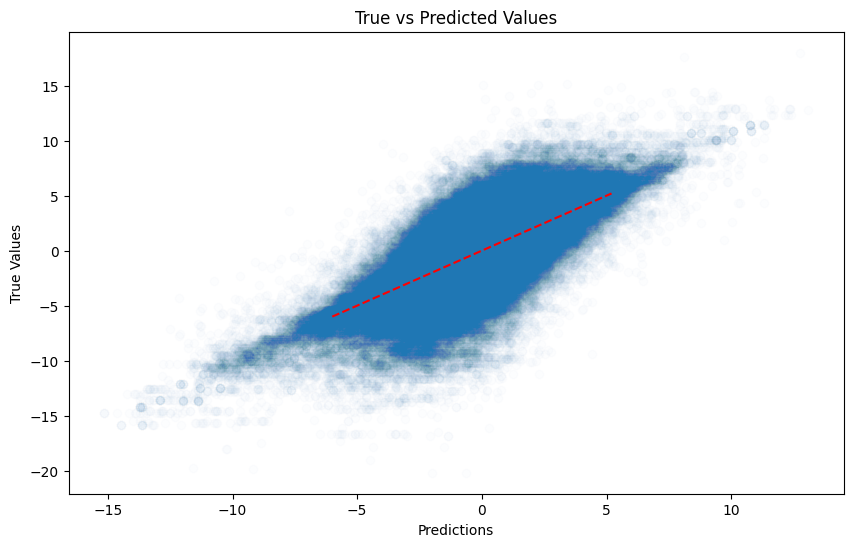

In [13]:
plyr_long, plyr_epa_forecast = plyr_epa_forecaster(pbp_data, depth_charts, context_forecast_df, diagnostics=True, d_snaps=4, pca=False)

In [12]:
plyr_epa_forecast.describe()

position_label,play_id,C1,C2,C3,C4,CB1,CB2,CB3,CB4,CB5,...,TE4,TE5,WR1,WR2,WR3,WR4,WR5,WR6,WR7,special1
count,33513.000000,30912.000000,10485.000000,1701.000000,136.000000,26007.000000,22805.000000,16375.000000,10686.000000,4727.000000,...,1844.000000,81.000000,22767.000000,21154.000000,14434.000000,9849.000000,5252.000000,2019.000000,175.000000,75.000000
mean,2126.932563,-0.028695,0.016586,-0.193565,0.032153,-0.044029,-0.041502,-0.089234,0.013894,-0.048097,...,-0.143096,0.254598,-0.040597,-0.045726,-0.052151,-0.020349,-0.096992,-0.087452,0.044865,0.854028
std,1247.552063,2.027491,1.978030,1.923843,1.750148,1.993735,1.972616,2.009083,1.964243,1.957082,...,1.774149,1.911086,1.985598,2.006680,1.944712,1.903831,1.941774,1.903884,1.963273,1.882525
min,36.000000,-15.378442,-14.781846,-10.782422,-4.342573,-14.850778,-13.456062,-16.127572,-13.959708,-13.778341,...,-12.841078,-6.955988,-13.185772,-14.792385,-12.683774,-13.103400,-13.013055,-9.200572,-5.110827,-2.527288
25%,1040.000000,-1.285951,-1.197943,-1.372087,-0.990043,-1.283807,-1.297733,-1.360653,-1.246341,-1.293684,...,-1.183203,-1.045167,-1.301458,-1.301507,-1.292546,-1.183888,-1.273238,-1.348598,-1.326414,-0.378700
50%,2132.000000,0.113940,0.149209,-0.053552,0.081148,0.090399,0.108108,0.038206,0.124055,0.047564,...,-0.170482,-0.028019,0.090711,0.074728,0.079685,0.098126,0.011311,0.023697,0.204483,0.542943
75%,3181.000000,1.267576,1.300066,1.081985,1.247916,1.225704,1.222759,1.219645,1.296169,1.225956,...,0.976141,1.595386,1.231060,1.248738,1.229887,1.217651,1.156631,1.118601,1.448811,1.846958
max,5899.000000,12.027781,9.631544,6.565416,4.193151,11.631279,11.154771,10.842875,10.335133,10.015639,...,8.130134,5.808988,11.986583,13.506209,9.023421,9.968267,9.052792,8.329656,5.415288,6.423394


Test MSE: 1.859, R2: 0.434


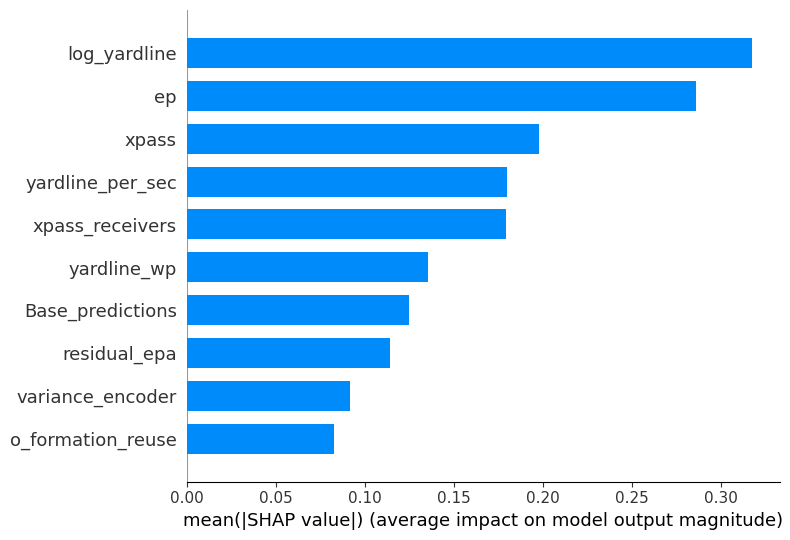

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Calculate prediction errors
plyr_long['prediction_error'] = plyr_long['future_plyr_epa'] - plyr_long['expected_plyr_epa']

# Merge ['yards_gained', 'was_pressure', 'time_to_throw', 'play_type', 'yardline_100', 'offense_personnel', 'run_location'] from pbp_data
plyr_long1 = plyr_long.merge(context_forecast_df, on=['game_id', 'play_id'], how='left')

# Define X, y
X = plyr_long1.drop(columns=['game_id', 'play_id', 'player_id', 'position_label', 'future_plyr_epa', 'expected_plyr_epa', 'prediction_error', 'epa'])
y = plyr_long1['prediction_error']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Remove infinite values
X_train = X_train[~X_train.isin([np.inf, -np.inf]).any(axis=1)]
X_test = X_test[~X_test.isin([np.inf, -np.inf]).any(axis=1)]
y_train = y_train[~X_train.isin([np.inf, -np.inf]).any(axis=1)]
y_test = y_test[~X_test.isin([np.inf, -np.inf]).any(axis=1)]

# Fill na values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

# Fit the model
model = XGBRegressor(n_estimators=5000, learning_rate=0.15, max_depth=5, reg_lambda=1.0, gamma=0.10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)
print(f'Test MSE: {mse:.3f}, R2: {rsquared:.3f}')

# Fit SHAP
import shap
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar', max_display=10)

## VOE Model

In [11]:
plyr_epa_forecast.columns

Index(['game_id', 'play_id', 'C1', 'C2', 'C3', 'C4', 'CB1', 'CB2', 'CB3',
       'CB4', 'CB5', 'CB6', 'CB7', 'CB8', 'DE1', 'DE2', 'DE3', 'DE4', 'DE5',
       'DE6', 'DE7', 'DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'DT7', 'FB1',
       'FB2', 'FS1', 'FS2', 'FS3', 'FS4', 'ILB1', 'ILB2', 'ILB3', 'ILB4',
       'ILB5', 'ILB6', 'LG1', 'LG2', 'LG3', 'LT1', 'LT2', 'LT3', 'MLB1',
       'MLB2', 'MLB3', 'NT1', 'NT2', 'NT3', 'OLB1', 'OLB2', 'OLB3', 'OLB4',
       'OLB5', 'OLB6', 'QB1', 'QB2', 'QB3', 'RB1', 'RB2', 'RB3', 'RB4', 'RB5',
       'RG1', 'RG2', 'RG3', 'RT1', 'RT2', 'RT3', 'SS1', 'SS2', 'SS3', 'SS4',
       'SS5', 'TE1', 'TE2', 'TE3', 'TE4', 'TE5', 'WR1', 'WR2', 'WR3', 'WR4',
       'WR5', 'WR6', 'WR7', 'special1'],
      dtype='object', name='position_label')

In [11]:
def get_position_groups(_):
    """
    Returns a dictionary with keys for 'offense', 'defense', and position groups,
    and values as lists of hard-coded position_labels.
    Ignores the input and uses a fixed list.
    """
    position_labels = [
        'C1', 'C2', 'C3', 'C4', 'CB1', 'CB2', 'CB3', 'CB4', 'CB5', 'CB6', 'CB7', 'CB8',
        'DE1', 'DE2', 'DE3', 'DE4', 'DE5', 'DE6', 'DE7', 'DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'DT7',
        'FB1', 'FB2', 'FS1', 'FS2', 'FS3', 'FS4', 'ILB1', 'ILB2', 'ILB3', 'ILB4', 'ILB5', 'ILB6',
        'LG1', 'LG2', 'LG3', 'LT1', 'LT2', 'LT3', 'MLB1', 'MLB2', 'MLB3', 'NT1', 'NT2', 'NT3',
        'OLB1', 'OLB2', 'OLB3', 'OLB4', 'OLB5', 'OLB6', 'QB1', 'QB2', 'QB3', 'RB1', 'RB2', 'RB3', 'RB4', 'RB5',
        'RG1', 'RG2', 'RG3', 'RT1', 'RT2', 'RT3', 'SS1', 'SS2', 'SS3', 'SS4', 'SS5',
        'TE1', 'TE2', 'TE3', 'TE4', 'TE5', 'WR1', 'WR2', 'WR3', 'WR4', 'WR5', 'WR6', 'WR7', 'special1'
    ]

    group_dict = {
        'offense': [p for p in position_labels if any(p.startswith(x) for x in [
            'QB', 'RB', 'FB', 'WR', 'TE', 'LT', 'LG', 'C', 'RG', 'RT'])],
        'defense': [p for p in position_labels if any(p.startswith(x) for x in [
            'DE', 'DT', 'NT', 'OLB', 'ILB', 'MLB', 'CB', 'FS', 'SS'])],
        'qbs': [p for p in position_labels if p.startswith('QB')],
        'rbs': [p for p in position_labels if p.startswith('RB') or p.startswith('FB')],
        'tes': [p for p in position_labels if p.startswith('TE')],
        'wrs': [p for p in position_labels if p.startswith('WR')],
        'ol': [p for p in position_labels if p.startswith(('LT', 'LG', 'C', 'RG', 'RT')) and not p.startswith('CB')],
        'dl': [p for p in position_labels if p.startswith(('DE', 'DT', 'NT'))],
        'lbs': [p for p in position_labels if p.startswith(('OLB', 'ILB', 'MLB'))],
        'cbs': [p for p in position_labels if p.startswith('CB')],
        'ss': [p for p in position_labels if p.startswith(('SS', 'FS'))],
        'special': [p for p in position_labels if p.startswith('special')]
    }

    return group_dict

MSE: 0.5237625050701574, R^2: 0.7269658719712222


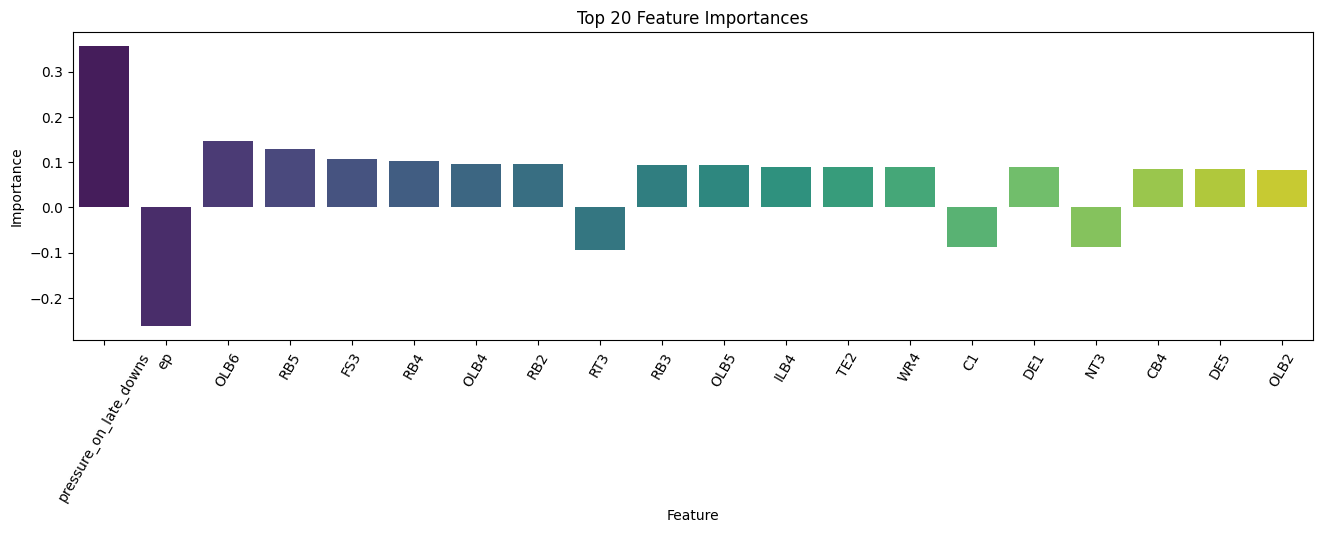

In [15]:
from sklearn.linear_model import Ridge
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Merge with future player performance data
pbp_data_copy = plyr_epa_forecast.merge(context_forecast_df, on=['game_id', 'play_id'], how='left')

X_train, X_test, y_train, y_test = train_test_split(pbp_data_copy.drop(columns=['game_id', 'play_id', 'residual_epa', 'epa', 'Base_predictions', 'shrinked_preds']), pbp_data_copy['residual_epa'], test_size=0.2, random_state=42)

# Fill na values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

from sklearn.linear_model import Ridge
model = Ridge(alpha=100.0)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rsquared = r2_score(y_test, y_preds)
print(f'MSE: {mse}, R^2: {rsquared}')

# coeficients
coeficients = model.coef_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': coeficients})
importance_df['Absolute Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False)

plt.figure(figsize=(16, 4))
sns.barplot(y='Importance', x='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xticks(rotation=60)
plt.show()

MSE: 0.35071311564514823, R^2: 0.816890504147847


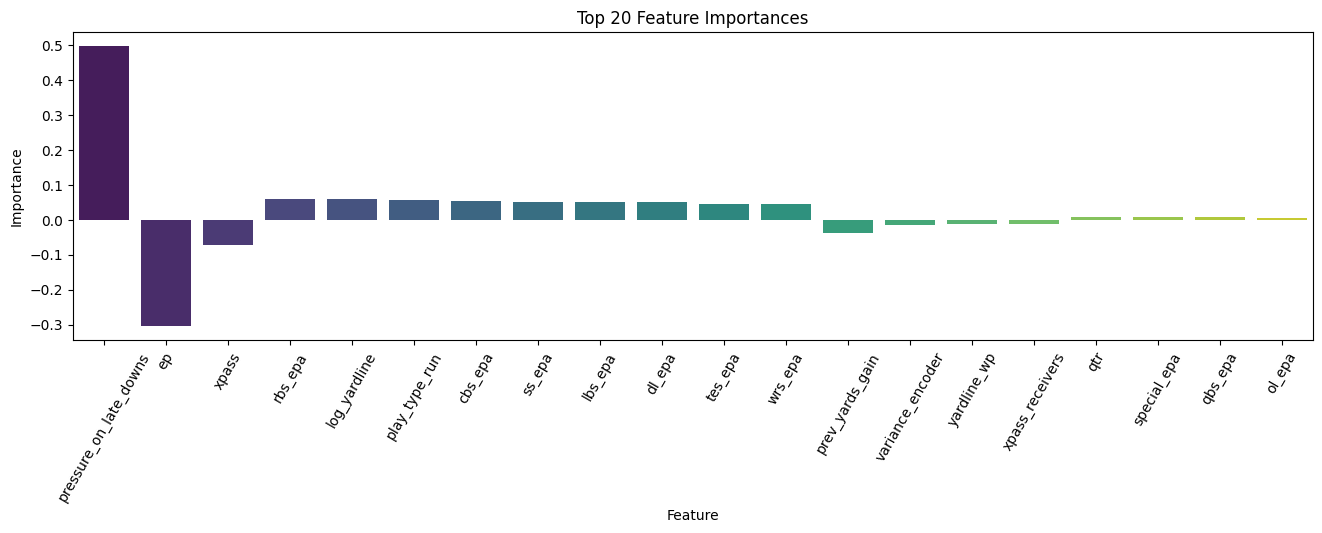

In [33]:
# Merge with future player performance data
pbp_data_copy = plyr_epa_forecast.merge(context_forecast_df, on=['game_id', 'play_id'], how='left')

# Get position groupings
pos_groups = get_position_groups(clean_depth_charts(depth_charts))

# Sum all columns for each position group (qb, rb, te, etc.)
for group in ['qbs', 'rbs', 'tes', 'wrs', 'ol', 'dl', 'lbs', 'cbs', 'ss', 'special', 'offense', 'defense']:
    group_cols = [col for col in pos_groups.get(group, []) if col in pbp_data_copy.columns]
    pbp_data_copy[f'{group}_epa'] = pbp_data_copy[group_cols].sum(axis=1)

X = pbp_data_copy[['qbs_epa', 'rbs_epa', 'tes_epa', 'wrs_epa', 'ol_epa', 'dl_epa', 'lbs_epa', 'cbs_epa', 'ss_epa', 'special_epa',
                   'o_formation_reuse', 'variance_encoder', 'ep', 'dist_down', 'd_coverage_reuse', 'play_type_run', 'log_yardline', 
                   'pressure_on_late_downs', 'qtr', 'yardline_wp', 'xpass_receivers', 'prev_yards_gain', 'temp', 'xpass', 'yardline_per_sec']].fillna(0)
y = pbp_data_copy['residual_epa'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fill na values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
ridge_grouped_preds = model.predict(X)
mse = mean_squared_error(y_test, y_preds)
rsquared = r2_score(y_test, y_preds)
print(f'MSE: {mse}, R^2: {rsquared}')

# coeficients
coeficients = model.coef_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': coeficients})
importance_df['Absolute Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False)

plt.figure(figsize=(16, 4))
sns.barplot(y='Importance', x='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xticks(rotation=60)
plt.show()

MSE: 0.09998872983710735, R^2: 0.7148981172589683
Combined Model - MSE: 0.6170569736466879, R^2: 0.6766486830578755


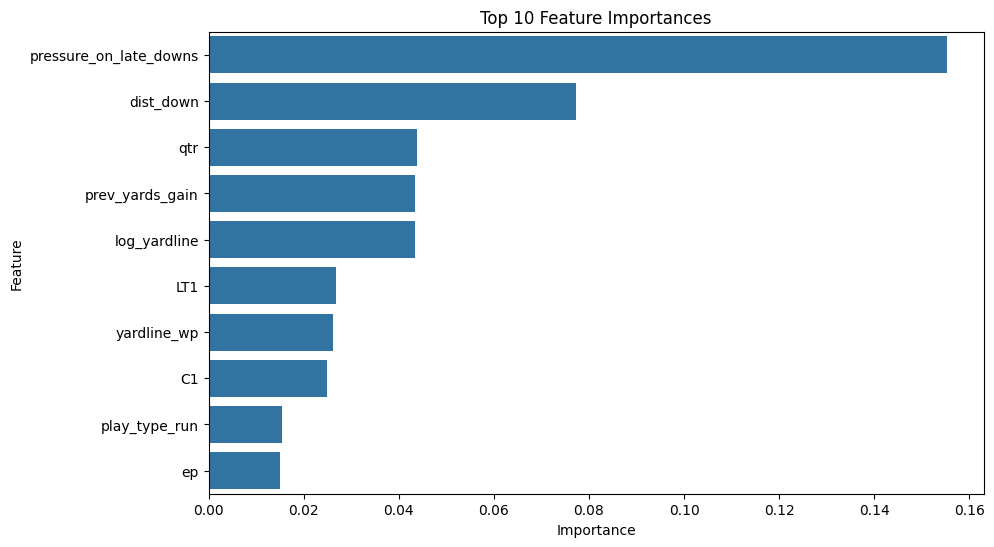

In [38]:
from xgboost import XGBRegressor

# Merge with future player performance data
pbp_data_copy = plyr_epa_forecast.merge(context_forecast_df, on=['game_id', 'play_id'], how='left')

X = pbp_data_copy.drop(columns=['game_id', 'play_id', 'residual_epa', 'epa', 'Base_predictions', 'shrinked_preds'])
y = pbp_data_copy['residual_epa'].fillna(0) - ridge_grouped_preds

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fill na values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

model = XGBRegressor(n_estimators=5000, learning_rate=0.20, max_depth=10, reg_lambda=1.0, gamma=0.10)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rsquared = r2_score(y_test, y_preds)
print(f'MSE: {mse}, R^2: {rsquared}')

# Calculate combined predictions
combined_preds = ridge_grouped_preds + model.predict(X)
mse = mean_squared_error(pbp_data_copy['residual_epa'].fillna(0), combined_preds)
rsquared = r2_score(pbp_data_copy['residual_epa'].fillna(0), combined_preds)
print(f'Combined Model - MSE: {mse}, R^2: {rsquared}')

# Feature importance
importances = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

Stacked MSE: 0.3184028838855304 R2: 0.8373738883787594


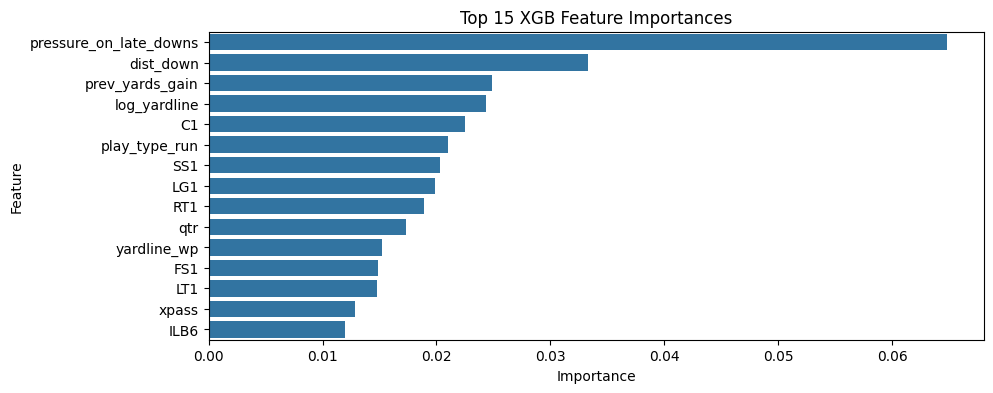

In [ ]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Merge with future player performance data
pbp_data_copy = plyr_epa_forecast.merge(context_forecast_df, on=['game_id', 'play_id'], how='left')

individual_features = [  # all columns except IDs and targets
    col for col in pbp_data_copy.columns
    if col not in ['game_id', 'play_id', 'residual_epa', 'epa', 'Base_predictions', 'shrinked_preds']
]

# Get position groupings
pos_groups = get_position_groups(clean_depth_charts(depth_charts))

# Sum all columns for each position group (qb, rb, te, etc.)
for group in ['qbs', 'rbs', 'tes', 'wrs', 'ol', 'dl', 'lbs', 'cbs', 'ss', 'special', 'offense', 'defense']:
    group_cols = [col for col in pos_groups.get(group, []) if col in pbp_data_copy.columns]
    pbp_data_copy[f'{group}_epa'] = pbp_data_copy[group_cols].sum(axis=1)

# Prepare your grouped feature set
grouped_features = [
    'qbs_epa', 'rbs_epa', 'tes_epa', 'wrs_epa', 'ol_epa', 'dl_epa', 'lbs_epa', 'cbs_epa', 'ss_epa', 'special_epa',
    'o_formation_reuse', 'variance_encoder', 'ep', 'dist_down', 'd_coverage_reuse', 'play_type_run', 'log_yardline', 
    'pressure_on_late_downs', 'qtr', 'yardline_wp', 'xpass_receivers', 'prev_yards_gain', 'temp', 'xpass', 'yardline_per_sec'
]

X_grouped = pbp_data_copy[grouped_features].fillna(0)
X_individual = pbp_data_copy[individual_features].fillna(0)
y = pbp_data_copy['residual_epa'].fillna(0).values

# 2. Out-of-fold stacking to avoid leakage
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_oof = np.zeros(len(y))
xgb_oof = np.zeros(len(y))

for train_idx, test_idx in kf.split(X_grouped):
    # Ridge on grouped features
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_grouped.iloc[train_idx], y[train_idx])
    ridge_pred = ridge.predict(X_grouped.iloc[test_idx])
    ridge_oof[test_idx] = ridge_pred

    # XGB on residuals, using individual features
    residuals = y[train_idx] - ridge.predict(X_grouped.iloc[train_idx])
    xgb = XGBRegressor(n_estimators=5000, learning_rate=0.01, max_depth=10, reg_lambda=1.0, gamma=0.50)
    xgb.fit(X_individual.iloc[train_idx], residuals)
    xgb_pred = xgb.predict(X_individual.iloc[test_idx])
    xgb_oof[test_idx] = xgb_pred

# 3. Final OOF prediction
final_pred = ridge_oof + xgb_oof

print('Stacked MSE:', mean_squared_error(y, final_pred), 'R2:', r2_score(y, final_pred))

# 4. Fit final models on all data for future prediction
ridge.fit(X_grouped, y)
ridge_full_pred = ridge.predict(X_grouped)
residuals_full = y - ridge_full_pred
xgb.fit(X_individual, residuals_full)
final_full_pred = ridge_full_pred + xgb.predict(X_individual)

# 5. XGB feature importance
importances = xgb.feature_importances_
feature_names = X_individual.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 XGB Feature Importances')
plt.show()

MSE: 0.32426448293671645, R^2: 0.8309629469611046


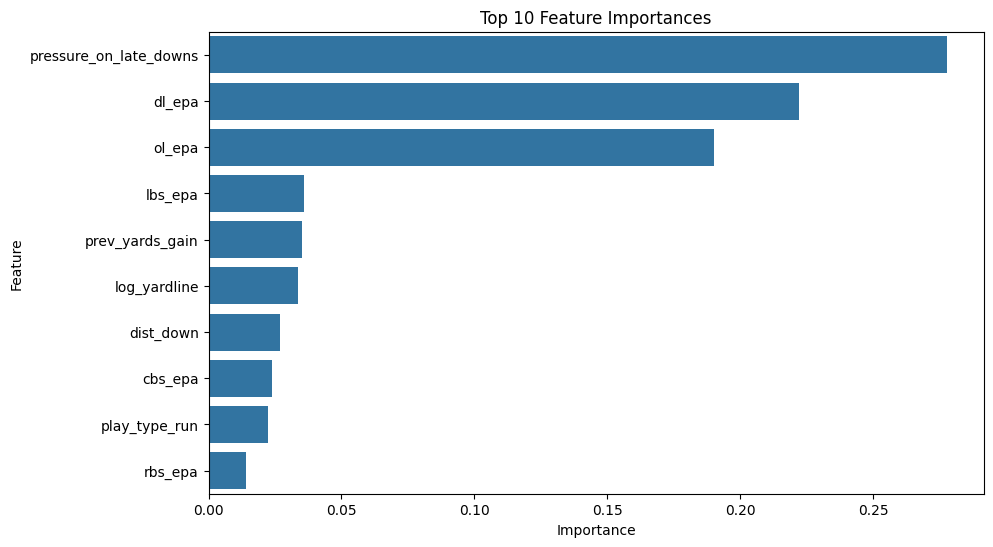

In [20]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Merge with future player performance data
pbp_data_copy = plyr_epa_forecast.merge(context_forecast_df, on=['game_id', 'play_id'], how='left')

# Get position groupings
pos_groups = get_position_groups(clean_depth_charts(depth_charts))

# Sum all columns for each position group (qb, rb, te, etc.)
for group in ['qbs', 'rbs', 'tes', 'wrs', 'ol', 'dl', 'lbs', 'cbs', 'ss', 'special', 'offense', 'defense']:
    group_cols = [col for col in pos_groups.get(group, []) if col in pbp_data_copy.columns]
    pbp_data_copy[f'{group}_epa'] = pbp_data_copy[group_cols].sum(axis=1)

X = pbp_data_copy[['qbs_epa', 'rbs_epa', 'tes_epa', 'wrs_epa', 'ol_epa', 'dl_epa', 'lbs_epa', 'cbs_epa', 'ss_epa', 'special_epa',
                   'o_formation_reuse', 'variance_encoder', 'ep', 'dist_down', 'd_coverage_reuse', 'play_type_run', 'log_yardline', 
                   'pressure_on_late_downs', 'qtr', 'yardline_wp', 'xpass_receivers', 'prev_yards_gain', 'temp', 'xpass', 'yardline_per_sec']].fillna(0)
y = pbp_data_copy['residual_epa'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=5000, learning_rate=0.20, max_depth=10, reg_lambda=1.0, gamma=0.01)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rsquared = r2_score(y_test, y_preds)
print(f'MSE: {mse}, R^2: {rsquared}')

# feature importance
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

MSE: 0.9897756505789027, R^2: 0.46722270686866885


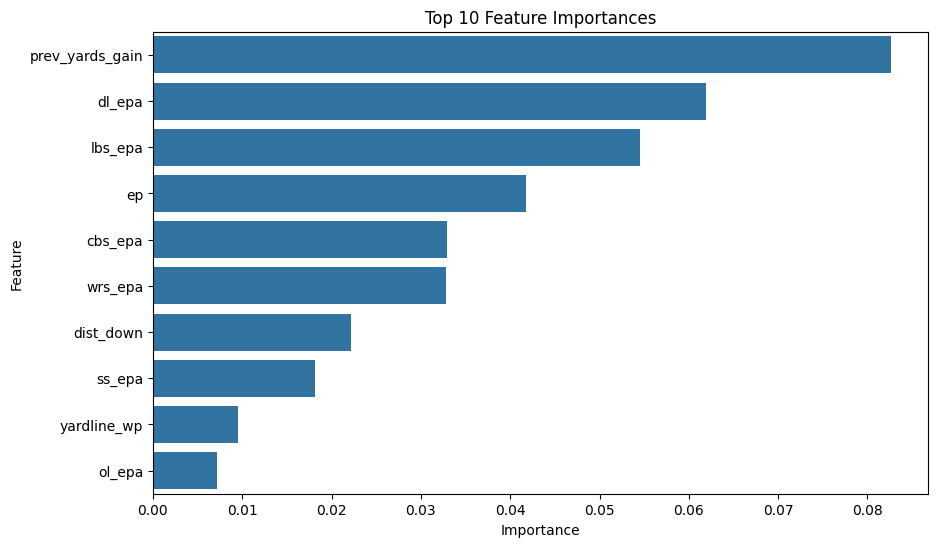

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

# Get position groupings
pos_groups = get_position_groups(clean_depth_charts(depth_charts))

# Sum all columns for each position group (qb, rb, te, etc.)
for group in ['qbs', 'rbs', 'tes', 'wrs', 'ol', 'dl', 'lbs', 'cbs', 'ss', 'special', 'offense', 'defense']:
    group_cols = [col for col in pos_groups.get(group, []) if col in pbp_data_copy.columns]
    pbp_data_copy[f'{group}_epa'] = pbp_data_copy[group_cols].sum(axis=1)

X = pbp_data_copy[['qbs_epa', 'rbs_epa', 'tes_epa', 'wrs_epa', 'ol_epa', 'dl_epa', 'lbs_epa', 'cbs_epa', 'ss_epa', 'special_epa',
                   'o_formation_reuse', 'variance_encoder', 'ep', 'dist_down', 'd_coverage_reuse', 'play_type_run', 'log_yardline', 
                   'pressure_on_late_downs', 'qtr', 'yardline_wp', 'xpass_receivers', 'prev_yards_gain', 'temp', 'xpass', 'yardline_per_sec']].fillna(0)
y = pbp_data_copy['residual_epa'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=99)

model = MLPRegressor(hidden_layer_sizes=(80, 20, 10), max_iter=5000, alpha=1.0, tol=0.01, learning_rate_init=0.05, early_stopping=True)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rsquared = r2_score(y_test, y_preds)
print(f'MSE: {mse}, R^2: {rsquared}')

# Input importance via permutation importance
from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [84]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define parameter grid for MLPRegressor
layer_list = [(50,), (25, 25,), (20, 15, 10, 5)]
alpha_list = [0.01, 10, 1000]
lr_list = [0.25, 0.0321, 0.00002]
tol_list = [2.5, 1e-4]

results = []

for layers in layer_list:
    for alpha in alpha_list:
        for lr in lr_list:
            for tol in tol_list:
                print(f"Training MLPRegressor with layers={layers}, alpha={alpha}, lr={lr}, tol={tol}")
                model = MLPRegressor(hidden_layer_sizes=layers, alpha=alpha, learning_rate_init=lr, tol=tol, max_iter=5000, early_stopping=True)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                rsquared = r2_score(y_test, y_pred)
                results.append({
                    'layers': layers,
                    'alpha': alpha,
                    'learning_rate_init': lr,
                    'tol': tol,
                    'mse': mse,
                    'r2': rsquared
                })

results_df = pd.DataFrame(results)
results_df = pd.get_dummies(results_df, columns=['layers'], prefix='layer')
model = Ridge(1)
model.fit(results_df.drop(columns=['mse', 'r2']), results_df['mse'])
coef = pd.Series(model.coef_, index=results_df.drop(columns=['mse', 'r2']).columns)
print(coef)
results_df.sort_values(by='mse', ascending=True).head(10)

Training MLPRegressor with layers=(50,), alpha=0.01, lr=0.25, tol=2.5
Training MLPRegressor with layers=(50,), alpha=0.01, lr=0.25, tol=0.0001
Training MLPRegressor with layers=(50,), alpha=0.01, lr=0.0321, tol=2.5
Training MLPRegressor with layers=(50,), alpha=0.01, lr=0.0321, tol=0.0001
Training MLPRegressor with layers=(50,), alpha=0.01, lr=2e-05, tol=2.5
Training MLPRegressor with layers=(50,), alpha=0.01, lr=2e-05, tol=0.0001
Training MLPRegressor with layers=(50,), alpha=10, lr=0.25, tol=2.5
Training MLPRegressor with layers=(50,), alpha=10, lr=0.25, tol=0.0001
Training MLPRegressor with layers=(50,), alpha=10, lr=0.0321, tol=2.5
Training MLPRegressor with layers=(50,), alpha=10, lr=0.0321, tol=0.0001
Training MLPRegressor with layers=(50,), alpha=10, lr=2e-05, tol=2.5
Training MLPRegressor with layers=(50,), alpha=10, lr=2e-05, tol=0.0001
Training MLPRegressor with layers=(50,), alpha=1000, lr=0.25, tol=2.5
Training MLPRegressor with layers=(50,), alpha=1000, lr=0.25, tol=0.0001

,alpha,learning_rate_init,tol,mse,r2,"layer_(20, 15, 10, 5)","layer_(25, 25)","layer_(50,)"
39,0.01,0.03210,0.0001,0.559114,0.708538,1,0,0
21,0.01,0.03210,0.0001,0.605287,0.684468,0,1,0
47,10.00,0.00002,0.0001,0.833211,0.565652,1,0,0
38,0.01,0.03210,2.5000,0.960796,0.499143,1,0,0
9,10.00,0.03210,0.0001,0.968621,0.495064,0,0,1
44,10.00,0.03210,2.5000,0.990597,0.483608,1,0,0
46,10.00,0.00002,2.5000,1.100305,0.426418,1,0,0
19,0.01,0.25000,0.0001,1.186887,0.381283,0,1,0
28,10.00,0.00002,2.5000,1.201834,0.373492,0,1,0
40,0.01,0.00002,2.5000,1.229102,0.359277,1,0,0


In [ ]:
# define parameters
lr = [0.25, 0.10, 0.001]
md = [2, 10]
lam = [0.0, 5, 1000]
gamma = [1, 0.02]

# Define the parameter grid
param_grid = {
    'learning_rate': lr,
    'max_depth': md,
    'lambda': lam,
    'gamma': gamma
}

results = []

# for loop over parameter grid
for lr in param_grid['learning_rate']:
    for md in param_grid['max_depth']:
        for lam in param_grid['lambda']:
            for gamma in param_grid['gamma']:
                print(f"Training model with lr={lr}, md={md}, lam={lam}, gamma={gamma}")
                model = XGBRegressor(learning_rate=lr, max_depth=md, reg_lambda=lam, gamma=gamma, n_estimators=5000)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                rsquared = r2_score(y_test, y_pred)
                results.append({
                    'learning_rate': lr,
                    'max_depth': md,
                    'lambda': lam,
                    'gamma': gamma,
                    'mse': mse,
                    'r2': rsquared
                })

Training model with lr=0.25, md=2, lam=1.0, gamma=1
Model performance: 0.5289997435674519
Training model with lr=0.25, md=2, lam=1.0, gamma=0.02
Model performance: 0.4921500171099256
Training model with lr=0.25, md=2, lam=10, gamma=1
Model performance: 0.5298343201630864
Training model with lr=0.25, md=2, lam=10, gamma=0.02
Model performance: 0.4883492290645229
Training model with lr=0.25, md=2, lam=1000, gamma=1
Model performance: 0.5577042582048347
Training model with lr=0.25, md=2, lam=1000, gamma=0.02
Model performance: 0.48910210552211386
Training model with lr=0.25, md=8, lam=1.0, gamma=1
Model performance: 0.5273365435122482
Training model with lr=0.25, md=8, lam=1.0, gamma=0.02
Model performance: 0.5207047518547849
Training model with lr=0.25, md=8, lam=10, gamma=1
Model performance: 0.5157856352494379
Training model with lr=0.25, md=8, lam=10, gamma=0.02
Model performance: 0.504428392769967
Training model with lr=0.25, md=8, lam=1000, gamma=1
Model performance: 0.5124297739593

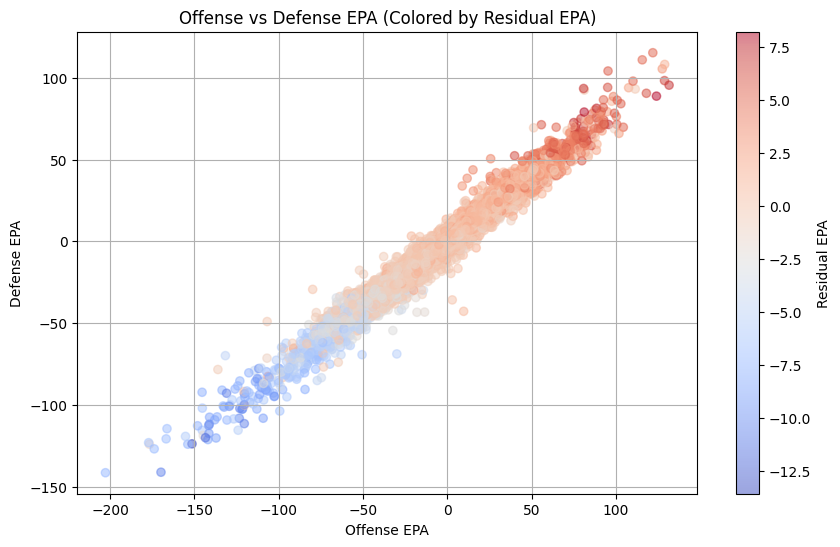

In [22]:
# Plot offense_epa and defense_epa, color code by residual_epa
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pbp_data_copy['offense_epa'], pbp_data_copy['defense_epa'], c=pbp_data_copy['residual_epa'], cmap='coolwarm', alpha=0.5)
plt.colorbar(scatter, label='Residual EPA')
plt.xlabel('Offense EPA')
plt.ylabel('Defense EPA')
plt.title('Offense vs Defense EPA (Colored by Residual EPA)')
plt.grid()
plt.show()

In [26]:
# Get mean future EPA by player and position group, then merge with player names
grouped = plyr_long.groupby(['player_id'])['future_plyr_epa'].sum().reset_index()
grouped = grouped.merge(depth_charts[['gsis_id', 'full_name']].drop_duplicates(), left_on='player_id', right_on='gsis_id', how='left')
grouped = grouped.sort_values(['future_plyr_epa'], ascending=[False])

# Example: show top 5 for each group
grouped

,player_id,future_plyr_epa,gsis_id,full_name
1451,00-0034796,835.4,00-0034796,Lamar Jackson
38,00-0025473,785.1,00-0025473,Marshal Yanda
1244,00-0034281,782.3,00-0034281,Bradley Bozeman
1420,00-0034752,782.3,00-0034752,Orlando Brown
648,00-0031958,698.8,00-0031958,Austin Reiter
...,...,...,...,...
802,00-0032580,-686.4,00-0032580,Jonathan Jones
355,00-0030421,-721.5,00-0030421,Jamie Collins
70,00-0027136,-742.3,00-0027136,Jason McCourty
234,00-0029542,-787.5,00-0029542,Stephon Gilmore


In [14]:
import pandas as pd
import numpy as np

def position_folds_from_counts(position_labels: pd.Series, n_folds: int = 10, min_positions_per_fold: int = 3):
    """
    Creates stratified folds for position labels based on their frequency in the dataset.
    
    Parameters:
    - position_labels: pd.Series of position labels (e.g., from depth_charts_copy['position_label'])
    - n_folds: Number of folds to create.
    - min_positions_per_fold: Minimum number of positions in each fold.
    
    Returns:
    - folds: List of lists, where each sublist contains position labels to be zeroed out in that fold.
    """
    pos_counts = position_labels.value_counts()
    positions = pos_counts.index.tolist()
    
    # Sort by frequency
    sorted_positions = pos_counts.sort_values(ascending=False).index.tolist()

    # Assign positions to folds in round-robin, stratified by frequency
    folds = [[] for _ in range(n_folds)]
    for i, pos in enumerate(sorted_positions):
        folds[i % n_folds].append(pos)
    
    # Ensure each fold meets the minimum size
    for fold in folds:
        if len(fold) < min_positions_per_fold:
            # Borrow from the largest fold
            largest_fold = max(folds, key=len)
            while len(fold) < min_positions_per_fold and len(largest_fold) > min_positions_per_fold:
                fold.append(largest_fold.pop())

    # Return as dict if preferred
    return {f'fold_{i}': fold for i, fold in enumerate(folds)}

In [76]:
pbp_long = pivot_long_both_sides(pivot_wide_both_sides(pbp_data[['offense_players', 'defense_players', 'game_id', 'play_id', 'play_type', 'season', 'week']]), depth_charts)
position_folds_from_counts(pbp_long['position_label'], 
                                   n_folds=22, 
                                   min_positions_per_fold=1)

{'fold_0': ['C1', 'TE2', 'DT4', 'DE6'],
 'fold_1': ['QB1', 'ILB2', 'OLB4', 'MLB3'],
 'fold_2': ['LT1', 'DT2', 'NT2', 'RB5'],
 'fold_3': ['RT1', 'CB4', 'LG2', 'NT3'],
 'fold_4': ['SS1', 'C2', 'SS3', 'FS4'],
 'fold_5': ['CB1', 'WR4', 'FB1', 'ILB5'],
 'fold_6': ['FS1', 'RB2', 'RB3', 'OLB6'],
 'fold_7': ['RG1', 'FS2', 'RT2', 'SS4'],
 'fold_8': ['LG1', 'NT1', 'FS3', 'WR7'],
 'fold_9': ['CB2', 'DE3', 'DE5', 'C4'],
 'fold_10': ['WR1', 'MLB1', 'CB6', 'FB2'],
 'fold_11': ['WR2', 'OLB3', 'WR6', 'TE5'],
 'fold_12': ['ILB1', 'SS2', 'TE4', 'special1'],
 'fold_13': ['OLB1', 'LT2', 'ILB4', 'SS5'],
 'fold_14': ['TE1', 'TE3', 'RB4', 'DE7'],
 'fold_15': ['DE1', 'DT3', 'C3', 'RG3'],
 'fold_16': ['RB1', 'WR5', 'MLB2', 'DT6'],
 'fold_17': ['DT1', 'CB5', 'OLB5', 'ILB6'],
 'fold_18': ['CB3', 'QB2', 'LT3', 'LG3'],
 'fold_19': ['DE2', 'ILB3', 'DT5', 'DT7'],
 'fold_20': ['OLB2', 'RG2', 'CB7', 'RT3'],
 'fold_21': ['WR3', 'DE4', 'QB3', 'CB8']}

In [138]:
def epa_over_expected_model(pbp_data, plyr_epa_forecast, context_forecast_df, diagnostics=False, model='default', folds=30):
    # Turn off warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Merge with future player performance data
    pbp_data_copy = plyr_epa_forecast.merge(context_forecast_df, on=['game_id', 'play_id'], how='left')

    # Define X, y
    X = pbp_data_copy.drop(columns=['game_id', 'play_id', 'epa', 'residual_epa', 'Base_predictions', 'shrinked_preds'], errors='ignore').fillna(0)
    y = pbp_data_copy['residual_epa'].fillna(0)

    # Initialize the mlp model
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBRegressor
    from sklearn.linear_model import Ridge
    from sklearn.neural_network import MLPRegressor

    # Initialize the model
    if model == 'default':
        model = Ridge(alpha=10.0)  # Default model is Ridge regression
    else:
        model = model  # Use the provided model

    # Get position groupings
    pos_groups = get_position_groups(clean_depth_charts(depth_charts))

    kf = KFold(n_splits=5, shuffle=True, random_state=99)

    oof_preds = np.zeros(len(X))
    oof_true = np.zeros(len(X))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Sum all columns for each position group (qb, rb, te, etc.)
        for group in ['qbs', 'rbs', 'tes', 'wrs', 'ol', 'dl', 'lbs', 'cbs', 'ss', 'special']:
            group_cols = [col for col in pos_groups.get(group, []) if col in X_train.columns]
            X_train[f'{group}_epa'] = X_train[group_cols].sum(axis=1)
            X_test[f'{group}_epa'] = X_test[group_cols].sum(axis=1)

        # Keep only the group epa columns and other features
        context_forecast_df_cols = context_forecast_df.drop(columns=['game_id', 'play_id', 'residual_epa', 'epa', 'Base_predictions', 'shrinked_preds']).columns
        X_train = X_train[[col for col in X_train.columns if col.endswith('_epa') or col in context_forecast_df_cols]]
        X_test = X_test[[col for col in X_test.columns if col.endswith('_epa') or col in context_forecast_df_cols]]

        # Ensure no NaNs
        X_train = X_train.fillna(0.0)
        X_test = X_test.fillna(0.0)
        y_train = y_train.fillna(0.0)
        y_test = y_test.fillna(0.0)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        oof_preds[test_index] = y_pred
        oof_true[test_index] = y_test

        if diagnostics:
            fold_mse = mean_squared_error(y_test, y_pred)
            fold_r2 = r2_score(y_test, y_pred)
            print(f'Fold MSE: {fold_mse:.3f}, R2: {fold_r2:.3f}')

    # Apply model to the entire dataset
    pbp_data_copy['voe_y1'] = oof_preds

    # Diagnostics
    if diagnostics:
        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(pbp_data_copy['voe_y1'], pbp_data_copy['residual_epa'], alpha=0.01, linewidths=1, label='Overall')
        plt.ylabel('Observed epa')
        plt.xlabel('Predicted epa')
        plt.title('True vs Predicted Values (Overall)')
        plt.legend()
        plt.plot([y.quantile(0.025), y.quantile(0.975)], [y.quantile(0.025), y.quantile(0.975)], color='red', linestyle='--')
        plt.grid()
        plt.show()

    # Generate folds of position groups
    pbp_long = pivot_long_both_sides(pivot_wide_both_sides(pbp_data[['offense_players', 'defense_players', 'game_id', 'play_id', 'play_type', 'season', 'week']]), depth_charts)
    pos_folds = position_folds_from_counts(pbp_long['position_label'], 
                                   n_folds=folds, 
                                   min_positions_per_fold=1)
    
    # Get the means for each column in plyr_epa_forecast
    col_means = plyr_epa_forecast.mean()
    
    # Store the results for causal inference
    results_by_fold = []
    
    # Loop through folds and apply the model
    for fold in pos_folds.values():
        # Now fold is a list of position labels
        fold_data = pbp_data_copy.copy()
        cols_in_fold = [col for col in fold if col in fold_data.columns]

        # Replace selected columns in fold with the column means
        fold_data[cols_in_fold] = col_means[cols_in_fold].values

        # Sum all columns for each position group (qb, rb, te, etc.)
        for group in ['qbs', 'rbs', 'tes', 'wrs', 'ol', 'dl', 'lbs', 'cbs', 'ss', 'special']:
            group_cols = [col for col in pos_groups.get(group, []) if col in fold_data.columns]
            fold_data[f'{group}_epa'] = fold_data[group_cols].sum(axis=1)

        # Keep only the group epa columns and other features
        context_forecast_df_cols = context_forecast_df.drop(columns=['residual_epa', 'epa', 'Base_predictions', 'shrinked_preds']).columns
        fold_data = fold_data[[col for col in fold_data.columns if col.endswith('_epa') or col in context_forecast_df_cols]]

        # Apply the model to the fold data
        X_fold = fold_data.drop(columns=['residual_epa', 'game_id', 'play_id'])

        # Scale the features
        X_fold_scaled = scaler.transform(X_fold)

        # Fill na
        X_fold_scaled = np.nan_to_num(X_fold_scaled)

        # Make predictions with pretrained model
        y_fold_pred = model.predict(X_fold_scaled)

        # Store results
        fold_results = pd.DataFrame({
            'game_id': fold_data['game_id'],
            'play_id': fold_data['play_id'],
            'voe_y0': y_fold_pred
        })

        # Filter pbp_long for the current fold
        fold_pbp_long = pbp_long[pbp_long['position_label'].isin(fold)]
        
        # Filter pbp_long for the current fold
        fold_results = fold_results.merge(fold_pbp_long[['game_id', 'play_id', 'player_id']], 
                                           on=['game_id', 'play_id'], how='left')

        results_by_fold.append(fold_results)

    # After the for loop over folds:
    results_by_fold_df = pd.concat(results_by_fold, ignore_index=True)
    results_by_fold_df = results_by_fold_df[['game_id', 'play_id', 'player_id', 'voe_y0']].copy()

    # --- PREPROCESSING PIPELINE ---
    pbp_long = pbp_long.merge(pbp_data_copy[['game_id', 'play_id', 'voe_y1', 'residual_epa']], on=['game_id', 'play_id'], how='left')
    pbp_long = pbp_long.merge(results_by_fold_df[['game_id', 'play_id', 'player_id', 'voe_y0']], 
                              on=['game_id', 'play_id', 'player_id'], how='left')
    pbp_long['causal_voe'] = pbp_long['voe_y1'] - pbp_long['voe_y0']

    return pbp_long

In [15]:
def epa_over_expected_model(pbp_data, plyr_epa_forecast, context_forecast_df, diagnostics=False, model='need_input', folds=30):
    # Turn off warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Merge with future player performance data
    pbp_data_copy = plyr_epa_forecast.merge(context_forecast_df, on=['game_id', 'play_id'], how='left')

    # Define X, y
    X = pbp_data_copy.drop(columns=['game_id', 'play_id', 'epa', 'residual_epa', 'Base_predictions', 'shrinked_preds'], errors='ignore').fillna(0)
    y = pbp_data_copy['residual_epa'].fillna(0)

    # Initialize the mlp model
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBRegressor
    from sklearn.linear_model import Ridge
    from sklearn.neural_network import MLPRegressor

    # Get position groupings
    pos_groups = get_position_groups(clean_depth_charts(depth_charts))

    kf = KFold(n_splits=4, shuffle=True, random_state=99)
    oof_preds = np.zeros(len(X))
    oof_true = np.zeros(len(X))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Ensure no NaNs
        X_train = X_train.fillna(0.0)
        X_test = X_test.fillna(0.0)
        y_train = y_train.fillna(0.0)
        y_test = y_test.fillna(0.0)

        # Create grouped features
        X_train_grouped = X_train.copy()
        X_test_grouped = X_test.copy()

        # Sum all columns for each position group (qb, rb, te, etc.)
        for group in ['qbs', 'rbs', 'tes', 'wrs', 'ol', 'dl', 'lbs', 'cbs', 'ss', 'special']:
            group_cols = [col for col in pos_groups.get(group, []) if col in X_train_grouped.columns]
            X_train_grouped[f'{group}_epa'] = X_train_grouped[group_cols].sum(axis=1)
            X_test_grouped[f'{group}_epa'] = X_test_grouped[group_cols].sum(axis=1)

        # Keep only the group epa columns and other features
        context_forecast_df_cols = context_forecast_df.drop(
            columns=['game_id', 'play_id', 'residual_epa', 'epa', 'Base_predictions', 'shrinked_preds']).columns
        X_train_grouped = X_train_grouped[[col for col in X_train_grouped.columns if col.endswith('_epa') or col in context_forecast_df_cols]]
        X_test_grouped = X_test_grouped[[col for col in X_test_grouped.columns if col.endswith('_epa') or col in context_forecast_df_cols]]

        scaler_grouped = StandardScaler()
        X_train_scaled = scaler_grouped.fit_transform(X_train_grouped)
        X_test_scaled = scaler_grouped.transform(X_test_grouped)

        # 1. Fit Ridge model
        ridge = Ridge(alpha=5.0)
        ridge.fit(X_train_scaled, y_train)
        y_pred_ridge = ridge.predict(X_test_scaled)

        # 2. Fit predefined model on Ridge residuals
        residuals_train = y_train - ridge.predict(X_train_scaled)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, residuals_train)
        y_pred_final = model.predict(X_test_scaled)

        # 3. Final prediction is Ridge + predefined model
        y_pred_final = y_pred_ridge + y_pred_final

        oof_preds[test_index] = y_pred_final
        oof_true[test_index] = y_test

        if diagnostics:
            fold_mse = mean_squared_error(y_test, y_pred_final)
            fold_r2 = r2_score(y_test, y_pred_final)
            print(f'Fold MSE: {fold_mse:.3f}, R2: {fold_r2:.3f}')
    
    # Calibrate the OOF predictions using Isotonic Regression
    from sklearn.isotonic import IsotonicRegression

    # After OOF predictions are filled
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(oof_preds, oof_true)
    oof_preds_calibrated = iso.transform(oof_preds)

    # Replace in your DataFrame
    pbp_data_copy['voe_y1'] = oof_preds_calibrated

    # Diagnostics
    if diagnostics:
        # Plot
        plt.figure(figsize=(8, 4))
        plt.scatter(pbp_data_copy['voe_y1'], pbp_data_copy['residual_epa'], alpha=0.01, linewidths=1, label='Overall')
        plt.ylabel('Observed epa')
        plt.xlabel('Predicted epa')
        plt.title('True vs Predicted Values (Overall)')
        plt.legend()
        plt.plot([y.quantile(0.025), y.quantile(0.975)], [y.quantile(0.025), y.quantile(0.975)], color='red', linestyle='--')
        plt.grid()
        plt.show()

        # coeficients
        coeficients = ridge.coef_
        feature_names = X_train_grouped.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': coeficients})
        importance_df['Absolute Importance'] = importance_df['Importance'].abs()
        importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False)
        plt.figure(figsize=(8, 4))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
        plt.title('Top 10 Coefficients')
        plt.show()

    # Generate folds of position groups
    pbp_long = pivot_long_both_sides(pivot_wide_both_sides(pbp_data[['offense_players', 'defense_players', 'game_id', 'play_id', 'play_type', 'season', 'week']]), depth_charts)
    pos_folds = position_folds_from_counts(pbp_long['position_label'], 
                                   n_folds=folds, 
                                   min_positions_per_fold=1)
    
    # Get the means for each column in plyr_epa_forecast
    col_means = plyr_epa_forecast.mean()
    
    # Store the results for causal inference
    results_by_fold = []
    
    # Loop through folds and apply the model
    for fold in pos_folds.values():
        fold_data = pbp_data_copy.copy()
        cols_in_fold = [col for col in fold if col in fold_data.columns]

        # Replace selected columns in fold with the column means
        fold_data[cols_in_fold] = col_means[cols_in_fold].values

        # --- Create grouped and non-grouped features for the fold ---
        # 1. Grouped features for Ridge
        fold_data_grouped = fold_data.copy()
        for group in ['qbs', 'rbs', 'tes', 'wrs', 'ol', 'dl', 'lbs', 'cbs', 'ss', 'special']:
            group_cols = [col for col in pos_groups.get(group, []) if col in fold_data_grouped.columns]
            fold_data_grouped[f'{group}_epa'] = fold_data_grouped[group_cols].sum(axis=1)
        context_forecast_df_cols = context_forecast_df.drop(
            columns=['residual_epa', 'epa', 'Base_predictions', 'shrinked_preds']).columns
        fold_data_grouped = fold_data_grouped[
            [col for col in fold_data_grouped.columns if col.endswith('_epa') or col in context_forecast_df_cols]
        ]

        # 2. Non-grouped features for XGBoost
        fold_data_nongrouped = fold_data.copy()
        fold_data_nongrouped = fold_data_nongrouped[
            [col for col in fold_data_nongrouped.columns if col not in ['game_id', 'play_id', 'residual_epa', 'epa', 'Base_predictions', 'shrinked_preds']]
        ].fillna(0)

        # --- Predict using the same structure as above ---
        # Ridge on grouped features
        X_fold_grouped = fold_data_grouped.drop(columns=['game_id', 'play_id', 'residual_epa'], errors='ignore')
        X_fold_grouped = X_fold_grouped.fillna(0.0)  # <--- Add this line
        X_fold_grouped_scaled = scaler_grouped.transform(X_fold_grouped)
        y_pred_ridge_fold = ridge.predict(X_fold_grouped_scaled)

        # XGBoost on non-grouped features
        X_fold_nongrouped = fold_data_nongrouped
        X_fold_nongrouped = X_fold_nongrouped.fillna(0.0)  # <--- Add this line
        X_fold_nongrouped_scaled = scaler.transform(X_fold_nongrouped)
        y_pred_final_fold = model.predict(X_fold_nongrouped_scaled)

        # Combine predictions
        y_fold_pred = y_pred_ridge_fold + y_pred_final_fold

        # Calibrate the fold predictions using Isotonic Regression
        iso = IsotonicRegression(out_of_bounds='clip')
        # Use available residual_epa if present, else zeros
        y_true_fold = fold_data['residual_epa'].fillna(0) if 'residual_epa' in fold_data else np.zeros(len(y_fold_pred))
        iso.fit(y_fold_pred, y_true_fold)
        y_fold_pred = iso.transform(y_fold_pred)

        # Store results
        fold_results = pd.DataFrame({
            'game_id': fold_data['game_id'],
            'play_id': fold_data['play_id'],
            'voe_y0': y_fold_pred
        })

        fold_pbp_long = pbp_long[pbp_long['position_label'].isin(fold)]
        fold_results = fold_results.merge(fold_pbp_long[['game_id', 'play_id', 'player_id']],
                                         on=['game_id', 'play_id'], how='left')

        results_by_fold.append(fold_results)

    # After the for loop over folds:
    results_by_fold_df = pd.concat(results_by_fold, ignore_index=True)
    results_by_fold_df = results_by_fold_df[['game_id', 'play_id', 'player_id', 'voe_y0']].copy()

    # --- PREPROCESSING PIPELINE ---
    pbp_long = pbp_long.merge(pbp_data_copy[['game_id', 'play_id', 'voe_y1', 'residual_epa']], on=['game_id', 'play_id'], how='left')
    pbp_long = pbp_long.merge(results_by_fold_df[['game_id', 'play_id', 'player_id', 'voe_y0']], 
                              on=['game_id', 'play_id', 'player_id'], how='left')
    pbp_long['causal_voe'] = pbp_long['voe_y1'] - pbp_long['voe_y0']

    return pbp_long

In [16]:
def epa_over_expected_model(pbp_data, plyr_epa_forecast, context_forecast_df, depth_charts,
                            diagnostics=False, n_folds_positions=30, model=None):
    """
    Produces causal VOE measure per player by:
     - training an ensemble model to predict residual_epa from player-level ratings + context
     - creating treatment folds where selected position ratings are replaced with column means for that position
     - computing difference between full-model prediction (voe_y1) and treatment (voe_y0)
    """
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBRegressor
    from sklearn.linear_model import Ridge
    from sklearn.neural_network import MLPRegressor

    # Merge pipelines, keep columns from both with safe join
    df = plyr_epa_forecast.merge(context_forecast_df, on=['game_id','play_id'], how='left', suffixes=('_plyr','_ctx'))

    # Ensure residual_epa exists and fillna
    if 'residual_epa' not in df.columns:
        df['residual_epa'] = df['epa'] - df['context_expected_epa']
    df['residual_epa'] = df['residual_epa'].fillna(0)

    # Build full feature matrix X (player rating columns assumed present in plyr_epa_forecast)
    # We exclude identifiers and the target/residuals themselves
    drop = ['game_id','play_id','epa','context_expected_epa','residual_epa','expected_plyr_epa','shrinked_preds','Base_predictions']  # adjust as needed
    X = df.drop(columns=[c for c in drop if c in df.columns], errors='ignore').fillna(0)
    y = df['residual_epa'].values

    # get mapping from depth charts to positions
    pos_groups = get_position_groups(clean_depth_charts(depth_charts))

    # Build list of position columns that originate from plyr_epa_forecast (player rating columns)
    # Identify columns that represent player-level predicted EPA — adapt naming if necessary
    player_cols = [c for c in X.columns if any(part in c.lower() for part in ['qb','rb','wr','te','ol','dl','lb','cb','s','special'])]
    # fallback: everything numeric in X
    if len(player_cols) == 0:
        player_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    # TRAIN: OOF approach for the control model (voe_y1)
    # We'll use ensemble: Ridge on grouped features (coarse) + XGB on original features residuals
    # Prepare grouped features (sum by coarse groups) once using full dataset column mapping
    group_names = list(pos_groups.keys())
    # Create group -> columns intersection with X
    group_to_cols = {}
    for g in group_names:
        group_to_cols[g] = [c for c in X.columns if c in pos_groups.get(g, [])]

    # Build grouped DF for the whole dataset (safe sums; if no cols -> zeros)
    grouped_df = pd.DataFrame(index=X.index)
    for g in group_names:
        cols = [c for c in group_to_cols[g] if c in X.columns]
        if cols:
            grouped_df[f'{g}_epa'] = X[cols].sum(axis=1)
        else:
            grouped_df[f'{g}_epa'] = 0.0

    # Combine grouped + context features (context features come from context_forecast_df)
    context_cols = [c for c in context_forecast_df.columns if c not in ['game_id','play_id','epa','context_expected_epa','residual_epa','shrinked_preds','Base_predictions']]
    # Ensure context cols exist in X or df
    context_cols = [c for c in context_cols if c in df.columns]
    X_grouped_full = pd.concat([grouped_df.reset_index(drop=True), df[context_cols].reset_index(drop=True)], axis=1).fillna(0)

    # OOF training (split using KFold) for overall model
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X_grouped_full))
    oof_true = np.zeros(len(X_grouped_full))

    # models and scalers to retain
    ridge = Ridge(alpha=5.0)

    # Keep scaler objects for later transforms
    scaler_grouped = StandardScaler()
    scaler_full = StandardScaler()

    for train_idx, test_idx in kf.split(X_grouped_full):
        # grouped features
        Xg_train = X_grouped_full.iloc[train_idx].fillna(0)
        Xg_test = X_grouped_full.iloc[test_idx].fillna(0)
        # full features for xgb (use original player-level + context) for residual modeling
        Xfull_train = X.iloc[train_idx].fillna(0)
        Xfull_test = X.iloc[test_idx].fillna(0)
        y_train = y[train_idx]
        y_test = y[test_idx]

        # scale grouped features for ridge
        Xg_train_s = scaler_grouped.fit_transform(Xg_train)
        Xg_test_s = scaler_grouped.transform(Xg_test)

        ridge.fit(Xg_train_s, y_train)
        y_ridge_pred = ridge.predict(Xg_test_s)

        # residuals to model with xgb
        res_train = y_train - ridge.predict(Xg_train_s)
        # scale full features for xgb
        Xfull_train_s = scaler_full.fit_transform(Xfull_train)
        Xfull_test_s = scaler_full.transform(Xfull_test)

        model.fit(Xfull_train_s, res_train)
        y_xgb_pred = model.predict(Xfull_test_s)

        y_final = y_ridge_pred + y_xgb_pred
        oof_preds[test_idx] = y_final
        oof_true[test_idx] = y_test

        if diagnostics:
            print('Fold MSE:', mean_squared_error(y_test, y_final), 'R2:', r2_score(y_test, y_final))

    # Attach OOF predictions as voe_y1
    df['voe_y1'] = oof_preds

    # Fit final models on full dataset for use in counterfactuals
    Xg_full = X_grouped_full.fillna(0)
    Xfull_full = X.fillna(0)

    Xg_full_s = scaler_grouped.fit_transform(Xg_full)
    Xfull_full_s = scaler_full.fit_transform(Xfull_full)

    ridge.fit(Xg_full_s, y)
    # residual model
    res_full = y - ridge.predict(Xg_full_s)
    model.fit(Xfull_full_s, res_full)

    if diagnostics:
        # Coefficients from ridge
        coef = pd.Series(ridge.coef_, index=Xg_full.columns)
        coef = coef.sort_values(key=abs, ascending=False)
        print('Top Ridge Coefficients:')
        print(coef.head(10))

    # -----------------------------
    # Create treatment folds and predict counterfactuals
    # -----------------------------
    # create position folds
    pbp_long = pivot_long_both_sides(pivot_wide_both_sides(pbp_data[['offense_players','defense_players','game_id','play_id','play_type','season','week']]), depth_charts)
    pos_folds = position_folds_from_counts(pbp_long['position_label'], n_folds=n_folds_positions, min_positions_per_fold=1)

    # compute column-means to replace missing ratings in treatment
    # restrict to player columns (columns that were present in plyr_epa_forecast)
    col_means = plyr_epa_forecast.mean().reindex(X.columns).fillna(0)

    results_by_fold = []
    for fold_name, fold_positions in pos_folds.items():
        fold_df = df.copy()

        # find columns in X that correspond to position labels in fold_positions
        # we assume plyr_epa_forecast columns named after depth chart position labels
        cols_in_fold = [c for c in X.columns if c in fold_positions]

        # Replace those columns with their column means (broadcast)
        if cols_in_fold:
            mean_vals = col_means.reindex(cols_in_fold).fillna(0).values
            fold_df.loc[:, cols_in_fold] = mean_vals  # broadcasting

        # Recompute grouped features for this fold (coarse sums)
        grouped_df_fold = pd.DataFrame(index=fold_df.index)
        for g in group_names:
            cols = [c for c in group_to_cols[g] if c in fold_df.columns]
            if cols:
                grouped_df_fold[f'{g}_epa'] = fold_df[cols].sum(axis=1)
            else:
                grouped_df_fold[f'{g}_epa'] = 0.0

        # Build the model input for this fold
        Xg_fold = pd.concat([grouped_df_fold.reset_index(drop=True), fold_df[context_cols].reset_index(drop=True)], axis=1).fillna(0)
        Xfull_fold = fold_df[X.columns].fillna(0)  # original full-features replaced as above

        # Reindex to train feature order and scale
        Xg_fold = Xg_fold.reindex(columns=Xg_full.columns, fill_value=0)
        Xfull_fold = Xfull_fold.reindex(columns=Xfull_full.columns, fill_value=0)

        Xg_fold_s = scaler_grouped.transform(Xg_fold)
        Xfull_fold_s = scaler_full.transform(Xfull_fold)

        # predictions using final models
        y_ridge_fold = ridge.predict(Xg_fold_s)
        y_xgb_fold = model.predict(Xfull_fold_s)
        y_fold_pred = y_ridge_fold + y_xgb_fold

        # store results (merge back to pbp_long with player ids)
        fold_results = pd.DataFrame({'game_id': fold_df['game_id'], 'play_id': fold_df['play_id'], 'voe_y0': y_fold_pred})
        # attach player ids for those positions in this fold
        fold_pbp_long = pbp_long[pbp_long['position_label'].isin(fold_positions)]
        fold_results = fold_results.merge(fold_pbp_long[['game_id','play_id','player_id']], on=['game_id','play_id'], how='left')
        results_by_fold.append(fold_results)

    results_by_fold_df = pd.concat(results_by_fold, ignore_index=True)
    results_by_fold_df = results_by_fold_df[['game_id','play_id','player_id','voe_y0']].copy()

    # Merge back into pbp_long and compute causal VOE
    pbp_long = pbp_long.merge(df[['game_id','play_id','voe_y1','residual_epa']], on=['game_id','play_id'], how='left')
    pbp_long = pbp_long.merge(results_by_fold_df, on=['game_id','play_id','player_id'], how='left')
    pbp_long['voe_y0'] = pbp_long['voe_y0'].fillna(0.0)
    pbp_long['causal_voe'] = pbp_long['voe_y1'] - pbp_long['voe_y0']

    return pbp_long

In [23]:
import nfl_data_py as nfl

# Define the years to import
yrs = range(2018, 2024)

# Play-by-Play Data
pbp_data = nfl.import_pbp_data(years=yrs)

# Weekly Fantasy Data
weekly_fantasy_data = nfl.import_weekly_data(years=yrs)

# Depth Charts
depth_charts = nfl.import_depth_charts(years=yrs)

2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.
Downcasting floats.


XGB SHORT
Fold MSE: 0.09741555119044622 R2: 0.9487448788618046
Fold MSE: 0.1027596851443186 R2: 0.94600319871286
Fold MSE: 0.10297550284137606 R2: 0.9466356354567498
Fold MSE: 0.10506898821466526 R2: 0.9446962098680103
Top Ridge Coefficients:
ep                       -0.508875
prev_yards_gain          -0.327457
yardline_wp              -0.239342
dl_epa                    0.217842
lbs_epa                   0.213105
defense_epa               0.209718
cbs_epa                   0.190151
ss_epa                    0.172382
wrs_epa                   0.160356
pressure_on_late_downs    0.125482
dtype: float64
MLP SHORT
Fold MSE: 0.2679055404317546 R2: 0.8590416954929678
Fold MSE: 0.27477040271949066 R2: 0.855617280119196
Fold MSE: 0.26997693472198175 R2: 0.8600915055985117
Fold MSE: 0.2868028882554101 R2: 0.8490393120668519
Top Ridge Coefficients:
ep                       -0.508875
prev_yards_gain          -0.327457
yardline_wp              -0.239342
dl_epa                    0.217842
lbs_epa  

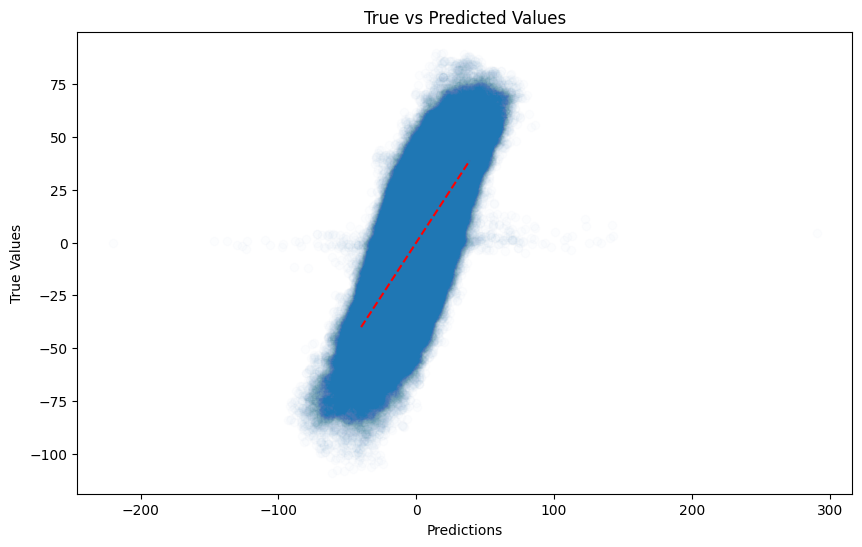

XGB LONG
Fold MSE: 1.7923515050778316 R2: 0.05695556415431147
Fold MSE: 1.8028572193885242 R2: 0.05265841475001731
Fold MSE: 1.8252968545470523 R2: 0.05408758337658959
Fold MSE: 1.7825442869226111 R2: 0.061745460577438016
Top Ridge Coefficients:
d_coverage_reuse    0.137030
yardline_wp        -0.128067
ep                 -0.119988
dl_epa              0.088051
wrs_epa             0.087833
xpass               0.079288
dist_down          -0.069874
tes_epa             0.067716
rbs_epa             0.066058
qtr                -0.065746
dtype: float64
MLP LONG
Fold MSE: 1.79239714826362 R2: 0.05693154902543196
Fold MSE: 1.7992555210499386 R2: 0.05455098759326504
Fold MSE: 1.837392033700686 R2: 0.04781957271618342
Fold MSE: 1.7959634957170039 R2: 0.054682167026098294
Top Ridge Coefficients:
d_coverage_reuse    0.137030
yardline_wp        -0.128067
ep                 -0.119988
dl_epa              0.088051
wrs_epa             0.087833
xpass               0.079288
dist_down          -0.069874
tes

KeyError: 'Column not found: causal_voe'

In [ ]:
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd
import numpy as np

xgb = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.15,
    max_depth=10,
    reg_lambda=0.1,
    gamma=0.05,
    colsample_bytree=1.0)

mlp = MLPRegressor(max_iter=5000, 
                   hidden_layer_sizes=(100, 50), 
                   alpha=1.0, 
                   tol=0.0025, 
                   learning_rate_init=0.025, 
                   early_stopping=True)


#plyr_long, plyr_epa_forecast = plyr_epa_forecaster(pbp_data, depth_charts, context_forecast_df, diagnostics=True, d_snaps=4, pca=False)
print("XGB SHORT")
xgb_short = epa_over_expected_model(pbp_data, plyr_epa_forecast, context_forecast_df, model=xgb, diagnostics=True, n_folds_positions=30, depth_charts=depth_charts)
xgb_short = xgb_short.groupby(['player_id', 'season', 'game_id'])[['causal_voe', 'residual_epa']].sum().reset_index()
xgb_short['week'] = xgb_short['game_id'].astype(str).str[5:7].astype(int)
xgb_short = xgb_short.rename(columns={'causal_voe': 'xgb_short'})

print("MLP SHORT")
mlp_short = epa_over_expected_model(pbp_data, plyr_epa_forecast, context_forecast_df, model=mlp, diagnostics=True, n_folds_positions=30, depth_charts=depth_charts)
mlp_short = mlp_short.groupby(['player_id', 'season', 'game_id'])[['causal_voe', 'residual_epa']].sum().reset_index()
mlp_short['week'] = mlp_short['game_id'].astype(str).str[5:7].astype(int)
mlp_short = mlp_short.rename(columns={'causal_voe': 'mlp_short'})

plyr_long, plyr_epa_forecast = plyr_epa_forecaster(pbp_data, depth_charts, context_forecast_df, diagnostics=True, d_snaps=150, pca=False)
print("XGB LONG")
xgb_long = epa_over_expected_model(pbp_data, plyr_epa_forecast, context_forecast_df, model=xgb, diagnostics=True, n_folds_positions=30, depth_charts=depth_charts)
xgb_long = xgb_long.groupby(['player_id', 'season', 'game_id'])[['causal_voe', 'residual_epa']].sum().reset_index()
xgb_long['week'] = xgb_long['game_id'].astype(str).str[5:7].astype(int)
xgb_long = xgb_long.rename(columns={'causal_voe': 'xgb_long'})

print("MLP LONG")
mlp_long = epa_over_expected_model(pbp_data, plyr_epa_forecast, context_forecast_df, model=mlp, diagnostics=True, n_folds_positions=30, depth_charts=depth_charts)
mlp_long = mlp_long.groupby(['player_id', 'season', 'game_id'])[['causal_voe', 'residual_epa']].sum().reset_index()
mlp_long['week'] = mlp_long['game_id'].astype(str).str[5:7].astype(int)
mlp_long = mlp_long.rename(columns={'causal_voe': 'mlp_long'})

# Combine model outputs on player-season-week level
causal_voe = xgb_short.merge(mlp_short, on=['player_id', 'season', 'week', 'residual_epa', 'game_id'], how='outer')
causal_voe = causal_voe.merge(xgb_long, on=['player_id', 'season', 'week', 'residual_epa', 'game_id'], how='outer')
causal_voe = causal_voe.merge(mlp_long, on=['player_id', 'season', 'week', 'residual_epa', 'game_id'], how='outer')

pbp_weekly = causal_voe.merge(weekly_fantasy_data[['player_id', 'season', 'week', 'fantasy_points_ppr']], on=['player_id', 'season', 'week'], how='left')
pbp_weekly = pbp_weekly.sort_values(['player_id', 'season', 'week'])
pbp_weekly['future_fantasy_points'] = pbp_weekly.groupby(['player_id', 'season'])['fantasy_points_ppr'].shift(-1)
pbp_weekly['future_xgb_short'] = pbp_weekly.groupby(['player_id', 'season'])['xgb_short'].shift(-1)
pbp_weekly['future_xgb_long'] = pbp_weekly.groupby(['player_id', 'season'])['xgb_long'].shift(-1)
pbp_weekly['future_mlp_short'] = pbp_weekly.groupby(['player_id', 'season'])['mlp_short'].shift(-1)
pbp_weekly['future_mlp_long'] = pbp_weekly.groupby(['player_id', 'season'])['mlp_long'].shift(-1)
pbp_weekly['future_residual_epa'] = pbp_weekly.groupby(['player_id', 'season'])['residual_epa'].shift(-1)

pbp_weekly.drop_duplicates(subset=['player_id', 'season', 'week'], inplace=True)

# Merge with cleaned depth charts
pbp_weekly = pbp_weekly.merge(clean_depth_charts(depth_charts)[['season', 'week', 'gsis_id', 'position_label', 'full_name', 'formation', 'club_code']],
                              left_on=['season', 'week', 'player_id'], 
                              right_on=['season', 'week', 'gsis_id'], how='left')

# Save data as excel c:\Users\Jack\Documents\GitHub\FFInsights\data
pbp_weekly.to_excel('c:\\Users\\Jack\\Documents\\GitHub\\FFInsights\\data\\voe_weekly_data.xlsx', index=False)

In [34]:
# Combine model outputs on player-season-week level
causal_voe = xgb_short.merge(mlp_short, on=['player_id', 'season', 'week', 'residual_epa', 'game_id'], how='outer')
causal_voe = causal_voe.merge(xgb_long, on=['player_id', 'season', 'week', 'residual_epa', 'game_id'], how='outer')
causal_voe = causal_voe.merge(mlp_long, on=['player_id', 'season', 'week', 'residual_epa', 'game_id'], how='outer')

pbp_weekly = causal_voe.merge(weekly_fantasy_data[['player_id', 'season', 'week', 'fantasy_points_ppr']], on=['player_id', 'season', 'week'], how='left')
pbp_weekly = pbp_weekly.sort_values(['player_id', 'season', 'week'])
pbp_weekly['future_fantasy_points'] = pbp_weekly.groupby(['player_id', 'season'])['fantasy_points_ppr'].shift(-1)
pbp_weekly['future_xgb_short'] = pbp_weekly.groupby(['player_id', 'season'])['xgb_short'].shift(-1)
pbp_weekly['future_xgb_long'] = pbp_weekly.groupby(['player_id', 'season'])['xgb_long'].shift(-1)
pbp_weekly['future_mlp_short'] = pbp_weekly.groupby(['player_id', 'season'])['mlp_short'].shift(-1)
pbp_weekly['future_mlp_long'] = pbp_weekly.groupby(['player_id', 'season'])['mlp_long'].shift(-1)
pbp_weekly['future_residual_epa'] = pbp_weekly.groupby(['player_id', 'season'])['residual_epa'].shift(-1)

pbp_weekly.drop_duplicates(subset=['player_id', 'season', 'week'], inplace=True)

# Merge with cleaned depth charts
pbp_weekly = pbp_weekly.merge(clean_depth_charts(depth_charts)[['season', 'week', 'gsis_id', 'position_label', 'full_name', 'formation', 'club_code']],
                              left_on=['season', 'week', 'player_id'], 
                              right_on=['season', 'week', 'gsis_id'], how='left')

# Save data as excel c:\Users\Jack\Documents\GitHub\FFInsights\data
pbp_weekly.to_excel('c:\\Users\\Jack\\Documents\\GitHub\\FFInsights\\data\\voe_weekly_data.xlsx', index=False)

In [33]:
# Correlation between causal_voe and future_fantasy_points
pbp_weekly[['future_xgb_short', 'future_xgb_long', 'future_mlp_short', 'future_mlp_long', 'future_fantasy_points', 'residual_epa']].corr()

,future_xgb_short,future_xgb_long,future_mlp_short,future_mlp_long,future_fantasy_points,residual_epa
future_xgb_short,1.000000,0.075059,0.185663,0.276872,0.064069,0.184884
future_xgb_long,0.075059,1.000000,-0.022985,0.186521,0.144389,0.079389
future_mlp_short,0.185663,-0.022985,1.000000,0.133339,0.411672,0.074927
future_mlp_long,0.276872,0.186521,0.133339,1.000000,0.280575,0.207547
future_fantasy_points,0.064069,0.144389,0.411672,0.280575,1.000000,0.084040
residual_epa,0.184884,0.079389,0.074927,0.207547,0.084040,1.000000


## Data Quality

make two separate voe models/metrics. first one is prospective and looks only at associational tendencies to extrapolate individual player impact. the second one is retrospective by using the first voe and individual player stats to account for within-play importance. the second voe uses stats (sacks, catches, blocks) to assign participation scores and allocates the unexplained epa accordingly.

In [139]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd
import numpy as np
import time

# Define lists of parameters
estimators = [5000]
learning_rates = [0.01, 0.25]
reg_lambdas = [0.1, 50]
max_depths = [3, 10]
gamma = [0.001, 5]

# Define models to test for all parameter combinations
xgb_models = {}
for n_est in estimators:
    for lr in learning_rates:
        for reg_lambda in reg_lambdas:
            for max_depth in max_depths:
                for g in gamma:
                    model_name = f"XGB_nest_{n_est}_lr_{lr}_lambda_{reg_lambda}_depth_{max_depth}_gamma_{g}"
                    xgb_models[model_name] = XGBRegressor(
                        n_estimators=n_est,
                        learning_rate=lr,
                        reg_lambda=reg_lambda,
                        max_depth=max_depth,
                        gamma=g,
                        random_state=42,
                        colsample_bytree=1.0, # the fraction of features to consider at each split
                    )

# Store results
results = []

# Feature engineering
pbp_weekly = weekly_fantasy_data.copy()

# Process each model
for model_name, model in xgb_models.items():
    start_time = time.time()

    # Generate causal VOE
    causal_voe = epa_over_expected_model(pbp_data, plyr_epa_forecast, context_forecast_df, model=model)
    causal_voe = causal_voe.groupby(['player_id', 'season', 'game_id'])[['causal_voe', 'residual_epa']].sum().reset_index()
    causal_voe['week'] = causal_voe['game_id'].astype(str).str[5:7].astype(int)

    # Merge and create future targets
    pbp_weekly = weekly_fantasy_data.merge(causal_voe, on=['player_id', 'season', 'week'], how='left')
    pbp_weekly = pbp_weekly.sort_values(['player_id', 'season', 'week'])
    pbp_weekly['future_fantasy_points'] = pbp_weekly.groupby(['player_id', 'season'])['fantasy_points_ppr'].shift(-1)
    pbp_weekly['future_causal_voe'] = pbp_weekly.groupby(['player_id', 'season'])['causal_voe'].shift(-1)
    pbp_weekly['future_residual_epa'] = pbp_weekly.groupby(['player_id', 'season'])['residual_epa'].shift(-1)

    pbp_weekly.drop_duplicates(subset=['player_id', 'season', 'week'], inplace=True)
    pbp_weekly.dropna(subset=['causal_voe', 'fantasy_points_ppr', 'future_fantasy_points'], inplace=True)

    # convert position to dummy variable
    pbp_weekly = pd.get_dummies(pbp_weekly, columns=['position'], drop_first=True)

    # Define features and targets
    position_cols = [col for col in pbp_weekly.columns if col.startswith('position_')]
    X = pbp_weekly[['causal_voe', 'fantasy_points_ppr'] + position_cols].fillna(0)
    X = X.drop(columns=['position_group'])
    y = pbp_weekly['future_residual_epa'].fillna(0)

    scaler = StandardScaler()
    rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=42)
    mse_list, r2_list, mae_list, var_list = [], [], [], []
    ridge = Ridge(alpha=1.0)

    for train_idx, test_idx in rkf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        ridge.fit(X_train_scaled, y_train)
        y_pred = ridge.predict(X_test_scaled)

        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))
        mae_list.append(mean_absolute_error(y_test, y_pred))
        var_list.append(explained_variance_score(y_test, y_pred))

    ols_model = sm.OLS(y, sm.add_constant(X)).fit()
    elapsed_time = time.time() - start_time

    results.append({
        'model_name': model_name,
        'mean_r2': round(np.mean(r2_list), 3),
        'mean_mse': round(np.mean(mse_list), 3),
        'coef': round(ridge.coef_[0], 4),
        'pval': round(ols_model.pvalues.get('causal_voe', np.nan), 4),
        'autocorrelation': round(pbp_weekly['causal_voe'].corr(pbp_weekly['future_causal_voe']), 3),
        'fantasy_correl': round(pbp_weekly['causal_voe'].corr(pbp_weekly['future_fantasy_points']), 3),
        'voe_variance': round(np.std(pbp_weekly['causal_voe']), 3),
        'sum_voe_is_zero': round(np.sum(pbp_weekly['causal_voe'] == 0), 1),
        'elapsed_time': round(elapsed_time, 1)
    })

# Define features and targets
position_cols = [col for col in pbp_weekly.columns if col.startswith('position_')]
X_base = pbp_weekly[['causal_voe', 'fantasy_points_ppr'] + position_cols].fillna(0)
X_base = X_base.drop(columns=['position_group'])
y_base = pbp_weekly['future_residual_epa'].fillna(0)

scaler = StandardScaler()
rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=42)
mse_list, r2_list, mae_list, var_list = [], [], [], []
ridge = Ridge(alpha=1.0)

for train_idx, test_idx in rkf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ridge.fit(X_train_scaled, y_train)
    y_pred = ridge.predict(X_test_scaled)

    mse_list.append(mean_squared_error(y_test, y_pred))
    r2_list.append(r2_score(y_test, y_pred))
    mae_list.append(mean_absolute_error(y_test, y_pred))
    var_list.append(explained_variance_score(y_test, y_pred))

ols_model = sm.OLS(y_base, sm.add_constant(X_base)).fit()

results.append({
    'model_name': 'Non-VOE',
    'mean_r2': round(np.mean(r2_list), 3),
    'mean_mse': round(np.mean(mse_list), 3),
    'coef': round(ridge.coef_[0], 4),
    'pval': round(ols_model.pvalues.get('fantasy_points_ppr', np.nan), 4),
    'autocorrelation': round(pbp_weekly['fantasy_points_ppr'].corr(pbp_weekly['future_fantasy_points']), 4),
    'fantasy_correl': round(pbp_weekly['fantasy_points_ppr'].corr(pbp_weekly['future_fantasy_points']), 3),
    'voe_variance': 0,
    'sum_voe_is_zero': 0,
    'elapsed_time': 0
})

# Final summary DataFrame
xgb_results_df = pd.DataFrame(results)

# Break model_name into n_estimators, lr, lambda, depth
xgb_results_df[['n_estimators', 'lr', 'lambda', 'depth', 'gamma']] = xgb_results_df['model_name'].str.extract(
    r'XGB_nest_(\d+)_lr_([\d.]+)_lambda_([\d.]+)_depth_(\d+)_gamma_([\d.]+)'
)

# Save results to Excel
xgb_results_df.to_excel('c:\\Users\\Jack\\Documents\\GitHub\\FFInsights\\data\\xgb_results.xlsx', index=False)

In [185]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd
import numpy as np
import time

# Define lists of parameters
layer_list = [(50, 50), (90, 10)]
alpha_list = [0.01, 10]
lr_list = [0.001, 0.25]
tol_list = [1e+1, 1e-4]

# Define models to test for all parameter combinations
mlp_models = {}
for layers in layer_list:
    for alpha in alpha_list:
        for lr in lr_list:
            for tol in tol_list:
                model_name = f"MLP_layers_{'_'.join(map(str, layers))}_alpha_{alpha}_lr_{lr}_tol_{tol}"
                mlp_models[model_name] = MLPRegressor(
                    hidden_layer_sizes=layers,
                    alpha=alpha,
                    learning_rate_init=lr,
                    max_iter=5000,
                    tol=tol,
                    random_state=9
                )

# Store results
results = []

# Feature engineering
pbp_weekly = weekly_fantasy_data.copy()

# Process each model
for model_name, model in mlp_models.items():
    start_time = time.time()

    # Generate causal VOE
    causal_voe = epa_over_expected_model(pbp_data, plyr_epa_forecast, context_forecast_df, model=model)
    causal_voe = causal_voe.groupby(['player_id', 'season', 'game_id'])[['causal_voe', 'residual_epa']].sum().reset_index()
    causal_voe['week'] = causal_voe['game_id'].astype(str).str[5:7].astype(int)

    # Merge and create future targets
    pbp_weekly = weekly_fantasy_data.merge(causal_voe, on=['player_id', 'season', 'week'], how='left')
    pbp_weekly = pbp_weekly.sort_values(['player_id', 'season', 'week'])
    pbp_weekly['future_fantasy_points'] = pbp_weekly.groupby(['player_id', 'season'])['fantasy_points_ppr'].shift(-1)
    pbp_weekly['future_causal_voe'] = pbp_weekly.groupby(['player_id', 'season'])['causal_voe'].shift(-1)
    pbp_weekly['future_residual_epa'] = pbp_weekly.groupby(['player_id', 'season'])['residual_epa'].shift(-1)

    pbp_weekly.drop_duplicates(subset=['player_id', 'season', 'week'], inplace=True)
    pbp_weekly.dropna(subset=['causal_voe', 'fantasy_points_ppr', 'future_fantasy_points'], inplace=True)

    # convert position to dummy variable
    pbp_weekly = pd.get_dummies(pbp_weekly, columns=['position'], drop_first=True)

    # Define features and targets
    position_cols = [col for col in pbp_weekly.columns if col.startswith('position_')]
    X = pbp_weekly[['causal_voe', 'fantasy_points_ppr'] + position_cols].fillna(0)
    X = X.drop(columns=['position_group'])
    y = pbp_weekly['future_residual_epa'].fillna(0)

    scaler = StandardScaler()
    rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=42)
    mse_list, r2_list, mae_list, var_list = [], [], [], []
    ridge = Ridge(alpha=1.0)

    for train_idx, test_idx in rkf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        ridge.fit(X_train_scaled, y_train)
        y_pred = ridge.predict(X_test_scaled)

        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))
        mae_list.append(mean_absolute_error(y_test, y_pred))
        var_list.append(explained_variance_score(y_test, y_pred))

    ols_model = sm.OLS(y, sm.add_constant(X)).fit()
    elapsed_time = time.time() - start_time

    results.append({
        'model_name': model_name,
        'mean_r2': round(np.mean(r2_list), 3),
        'mean_mse': round(np.mean(mse_list), 3),
        'coef': round(ridge.coef_[0], 4),
        'pval': round(ols_model.pvalues.get('causal_voe', np.nan), 4),
        'autocorrelation': round(pbp_weekly['causal_voe'].corr(pbp_weekly['future_causal_voe']), 3),
        'fantasy_correl': round(pbp_weekly['causal_voe'].corr(pbp_weekly['future_fantasy_points']), 3),
        'voe_variance': round(np.std(pbp_weekly['causal_voe']), 3),
        'sum_voe_is_zero': round(np.sum(pbp_weekly['causal_voe'] == 0), 1),
        'elapsed_time': round(elapsed_time, 1)
    })

# Define features and targets
position_cols = [col for col in pbp_weekly.columns if col.startswith('position_')]
X_base = pbp_weekly[['causal_voe', 'fantasy_points_ppr'] + position_cols].fillna(0)
X_base = X_base.drop(columns=['position_group'])
y_base = pbp_weekly['future_residual_epa'].fillna(0)
 
scaler = StandardScaler()
rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=42)
mse_list, r2_list, mae_list, var_list = [], [], [], []
ridge = Ridge(alpha=1.0)

for train_idx, test_idx in rkf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ridge.fit(X_train_scaled, y_train)
    y_pred = ridge.predict(X_test_scaled)

    mse_list.append(mean_squared_error(y_test, y_pred))
    r2_list.append(r2_score(y_test, y_pred))
    mae_list.append(mean_absolute_error(y_test, y_pred))
    var_list.append(explained_variance_score(y_test, y_pred))

ols_model = sm.OLS(y_base, sm.add_constant(X_base)).fit()

results.append({
    'model_name': 'Non-VOE',
    'mean_r2': round(np.mean(r2_list), 3),
    'mean_mse': round(np.mean(mse_list), 3),
    'coef': round(ridge.coef_[0], 4),
    'pval': round(ols_model.pvalues.get('fantasy_points_ppr', np.nan), 4),
    'autocorrelation': round(pbp_weekly['fantasy_points_ppr'].corr(pbp_weekly['future_fantasy_points']), 4),
    'fantasy_correl': round(pbp_weekly['fantasy_points_ppr'].corr(pbp_weekly['future_fantasy_points']), 3),
    'voe_variance': 0,
    'sum_voe_is_zero': 0,
    'elapsed_time': 0
})

# Final summary DataFrame
mlp_results_df = pd.DataFrame(results)

# Break model_name into layers, alpha, lr, tol
mlp_results_df[['layers', 'alpha', 'lr', 'tol']] = mlp_results_df['model_name'].str.extract(
    r'MLP_layers_([\d_]+)_alpha_([\d.]+)_lr_([\d.]+)_tol_([\de.-]+)'
)

# Save results to Excel
mlp_results_df.to_excel('c:\\Users\\Jack\\Documents\\GitHub\\FFInsights\\data\\mlp_results.xlsx', index=False)